# Refitting with non-negative least squares regression

In [1]:
from collections import Counter
import json
import itertools
import tqdm
import os

import numpy as np
import pandas as pd
from scipy.optimize import nnls  # non-negative least squares function

In [2]:
import matplotlib
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

## profile plot functions

In [3]:
snv_color = {
    'C>A' : '#1e9ef0ff', 
    'C>G' : '#333333ff', 
    'C>T' : '#e62725ff', 
    'T>A' : '#c7c6c7ff', 
    'T>C' : '#2bbc5bff', 
    'T>G' : '#fbbc05ff'
}

def plot_profile(frequencies, title='title', ylabels=[0, 0.1], ymax=0.3, output_f=None): 
    
    # Plot params
    fig, ax = plt.subplots(
        2, 
        sharex='col', 
        figsize=(12, 3), 
         gridspec_kw={'height_ratios': [0.05, 0.95]}
    )
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.01, 
                        hspace=0)
    
    plt.title(title, fontsize=14, pad=30)

    #### Top
    axis_key = 0
    ax[axis_key].spines['top'].set_visible(False)
    ax[axis_key].spines['right'].set_visible(False)
    ax[axis_key].spines['left'].set_visible(False)
    ax[axis_key].spines['bottom'].set_visible(False)

    ax[axis_key].set_yticks([])

    subs = 'C>A'
    rect1 = Rectangle((0, 0.15), 15.75, 0.5, color=snv_color[subs])
    ax[axis_key].add_patch(rect1)
    ax[axis_key].text(15.75/2, 0.9, subs, fontsize=11, weight='normal', ha='center')
    subs = 'C>G'
    rect1 = Rectangle((16,0.1), 15.75, 0.5, color=snv_color[subs])
    ax[axis_key].add_patch(rect1)
    ax[axis_key].text(16 + 15.75/2 -1, 0.9, subs, fontsize=11, weight='normal', ha='center')
    subs = 'C>T'
    rect1 = Rectangle((32,0.1), 15.75, 0.5, color=snv_color[subs])
    ax[axis_key].add_patch(rect1)
    ax[axis_key].text(32 + 15.75/2 -1, 0.9, subs, fontsize=11, weight='normal', ha='center')
    subs = 'T>A'
    rect1 = Rectangle((48,0.1), 15.75, 0.5, color=snv_color[subs])
    ax[axis_key].add_patch(rect1)
    ax[axis_key].text(48 + 15.75/2 -1, 0.9, subs, fontsize=11, weight='normal', ha='center')
    subs = 'T>C'
    rect1 = Rectangle((64,0.1), 15.75, 0.5, color=snv_color[subs])
    ax[axis_key].add_patch(rect1)
    ax[axis_key].text(64 + 15.75/2 -1, 0.9, subs, fontsize=11, weight='normal', ha='center')
    subs = 'T>G'
    rect1 = Rectangle((80,0.1), 15.75, 0.5, color=snv_color[subs])
    ax[axis_key].add_patch(rect1)
    ax[axis_key].text(80 + 15.75/2 -1, 0.9, subs, fontsize=11, weight='normal', ha='center')


    #### PLOT 1
    axis_key = 1

    probabilities = []
    colors = []
    labels = []
    for snv_type in ['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G']: 
        ref, alt = snv_type.split('>')
        for nuc5 in ['A', 'C', 'G', 'T']: 
            for nuc3 in ['A', 'C', 'G', 'T']: 
                trinucleotide = nuc5 + ref + nuc3
                trinucleotide_change = f'{trinucleotide}>{alt}'
                probabilities.append(frequencies.get(trinucleotide_change, 0))
                colors.append(snv_color[snv_type])
                labels.append(trinucleotide)

    ax[axis_key].bar(list(range(0, 96)), probabilities, width=0.8, bottom=None, align='center', color=colors)


    ########## Y axis
    ylabels_dict = {
        0: '', 
        1: 'Frequency'
    }

    ax[axis_key].set_yticks(ylabels)
    ax[axis_key].set_yticklabels(ylabels, fontsize=12, color='black', va="top", ha="center")
    ax[axis_key].set_xticks([])
    #ax[axis_key].set_xticks(list(range(0, 96)))
    #ax[axis_key].set_xticklabels(labels, fontsize=2, color='black', va="top", ha="center")
    plt.xticks(rotation=90)

    for key, value in ylabels_dict.items(): 
        ax[key].set_ylabel(value, fontsize=12, rotation=90, labelpad=2)
        ax[key].set_axisbelow(True)
        for tick in ax[key].yaxis.get_major_ticks():
            tick.label.set_fontsize(11) 

        for location in ['top', 'bottom', 'left', 'right']:
            ax[key].spines[location].set_linewidth(0.25)

        ax[key].tick_params(axis = "x", which = "both", bottom=False)
        ax[key].tick_params(axis = "y", which = "both", left=False)
        ax[key].tick_params(axis='y', which='major', pad=0)
        ax[key].tick_params(axis='x', which='major', pad=0)

    ax[axis_key].set_xlim(xmin=-1, xmax=96)
    ax[axis_key].set_ylim(ymin=0, ymax=ymax)
    
    if output_f: 
        plt.savefig(output_f, bbox_inches='tight', dpi=600)
#     plt.close()

## canonical sorting for contexts

In [4]:
catalog_96channels = []
catalog_96channels_format = []
for snv_type in ['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G']: 
    ref, alt = snv_type.split('>')
    for nuc5 in ['A', 'C', 'G', 'T']: 
        for nuc3 in ['A', 'C', 'G', 'T']: 
            trinucleotide = nuc5 + ref + nuc3
            catalog_96channels.append(f'{trinucleotide}>{alt}')
            catalog_96channels_format.append(f'{nuc5}[{snv_type}]{nuc3}')

In [5]:
print(catalog_96channels[:10])
print(catalog_96channels_format[:10])

['ACA>A', 'ACC>A', 'ACG>A', 'ACT>A', 'CCA>A', 'CCC>A', 'CCG>A', 'CCT>A', 'GCA>A', 'GCC>A']
['A[C>A]A', 'A[C>A]C', 'A[C>A]G', 'A[C>A]T', 'C[C>A]A', 'C[C>A]C', 'C[C>A]G', 'C[C>A]T', 'G[C>A]A', 'G[C>A]C']


## load mutation data

In [6]:
input_dir = '/workspace/projects/hartwig/hotspots/hotspotfinder/2022_01/germline/data'

In [7]:
mut_files = [
    f'{input_dir}/inputs/human/Goldman_2016.parsed.tsv',
    f'{input_dir}/inputs/human/Rahbari_2015.parsed.tsv', 
    f'{input_dir}/inputs/human/Sasani_2019__second_gen.dnms.parsed.tsv',
    f'{input_dir}/inputs/human/Sasani_2019__third_gen.dnms.parsed.tsv', 
    f'{input_dir}/inputs/human/Yuen_2017.parsed.tsv', 
    f'{input_dir}/inputs/human/Halldorsson_2019.parsed.tsv', 
    f'{input_dir}/inputs/human/An_2018.parsed.tsv']

## triplet abundances

### whole-genome abundance

In [20]:
# just an example 
fn = '/workspace/projects/sjd_pediatric_tumors/code/signature_data/context_genome_counts.json'

with open(fn, 'rt') as f: 
    genome_trinuc_counts = json.load(f)
    
genome_trinuc_counts_96 = [genome_trinuc_counts[t.split('>')[0]] for t in catalog_96channels]

In [21]:
genome_trinuc_counts_96

[115415924,
 66550070,
 14381094,
 92058521,
 105547494,
 75238490,
 15801067,
 101628641,
 82414099,
 68090507,
 13621251,
 80004082,
 112085858,
 88336615,
 12630597,
 126566213,
 115415924,
 66550070,
 14381094,
 92058521,
 105547494,
 75238490,
 15801067,
 101628641,
 82414099,
 68090507,
 13621251,
 80004082,
 112085858,
 88336615,
 12630597,
 126566213,
 115415924,
 66550070,
 14381094,
 92058521,
 105547494,
 75238490,
 15801067,
 101628641,
 82414099,
 68090507,
 13621251,
 80004082,
 112085858,
 88336615,
 12630597,
 126566213,
 117976329,
 76401029,
 105094288,
 142651503,
 73791042,
 96335416,
 115950255,
 114180747,
 64915540,
 54055728,
 86012414,
 83421918,
 119020255,
 112827451,
 108406418,
 219915599,
 117976329,
 76401029,
 105094288,
 142651503,
 73791042,
 96335416,
 115950255,
 114180747,
 64915540,
 54055728,
 86012414,
 83421918,
 119020255,
 112827451,
 108406418,
 219915599,
 117976329,
 76401029,
 105094288,
 142651503,
 73791042,
 96335416,
 115950255,
 11418

### region abundance

In [22]:
# change with the appropriate region path
fn = '/workspace/projects/sjd_pediatric_tumors/code/signature_data/context_twinstrand_mutagenesis_counts.json'

with open(fn, 'rt') as f: 
    region_trinuc_counts = json.load(f)
    
region_trinuc_counts_96 = [region_trinuc_counts[t.split('>')[0]] for t in catalog_96channels]

In [23]:
region_trinuc_counts_96

[51649070,
 29781412,
 6435595,
 41196542,
 47232910,
 33669514,
 7071038,
 45479208,
 36880626,
 30470764,
 6095562,
 35802134,
 50158853,
 39530975,
 5652241,
 56638867,
 51649070,
 29781412,
 6435595,
 41196542,
 47232910,
 33669514,
 7071038,
 45479208,
 36880626,
 30470764,
 6095562,
 35802134,
 50158853,
 39530975,
 5652241,
 56638867,
 51649070,
 29781412,
 6435595,
 41196542,
 47232910,
 33669514,
 7071038,
 45479208,
 36880626,
 30470764,
 6095562,
 35802134,
 50158853,
 39530975,
 5652241,
 56638867,
 52794861,
 34189754,
 47030098,
 63837096,
 33021775,
 43110469,
 51888185,
 51096323,
 29049954,
 24190146,
 38490886,
 37331629,
 53262022,
 50490718,
 48512289,
 98413076,
 52794861,
 34189754,
 47030098,
 63837096,
 33021775,
 43110469,
 51888185,
 51096323,
 29049954,
 24190146,
 38490886,
 37331629,
 53262022,
 50490718,
 48512289,
 98413076,
 52794861,
 34189754,
 47030098,
 63837096,
 33021775,
 43110469,
 51888185,
 51096323,
 29049954,
 24190146,
 38490886,
 37331629,


## signatures

In [24]:
sigs_hg38 = '/workspace/projects/sjd_pediatric_tumors/code/signature_data/COSMIC_v3.3.1_SBS_GRCh38.txt'
sigs_hg38_df = pd.read_csv(sigs_hg38, sep='\t', header=0)

# aware of the fact that the sorting of contexts might not be the canonical
# we create a new column with the correct index in the canonical context order
# and we sort the entries according to this index

sigs_hg38_df['canonical_index'] = sigs_hg38_df['Type'].apply(lambda r: catalog_96channels_format.index(r))
sigs_hg38_df = sigs_hg38_df.sort_values(by='canonical_index', axis=0)

In [188]:
all_signatures = [c for c in sigs_hg38_df.columns if c.startswith('SBS')]

profiles = []
for signature in all_signatures[:30]:
    hg38_profile = sigs_hg38_df[signature].tolist()    
    norm_profile = [p*trinuc_a/trinuc_g for p, trinuc_g, trinuc_a in zip(hg38_profile, 
                                                                         genome_trinuc_counts_96, 
                                                                         region_trinuc_counts_96)]
    norm_profile = [p / sum(norm_profile) for p in norm_profile]
    profiles.append(norm_profile)

X = np.array(profiles).T
X.shape

(96, 30)

In [189]:
X

array([[8.76022864e-04, 5.79005907e-07, 2.09197493e-02, ...,
        1.57722172e-04, 6.04617164e-03, 8.44506730e-04],
       [2.22011957e-03, 1.45504530e-04, 1.63431920e-02, ...,
        2.33488179e-03, 9.45179236e-05, 3.97419647e-04],
       [1.79727210e-04, 5.36186080e-05, 1.80754881e-03, ...,
        3.03318761e-04, 7.90362418e-04, 1.02308500e-07],
       ...,
       [5.52133365e-05, 7.12259636e-05, 6.40123037e-03, ...,
        3.85871747e-04, 7.66715979e-04, 5.40179288e-18],
       [5.77613848e-04, 9.54312688e-05, 8.11290411e-03, ...,
        1.31871734e-04, 5.61498393e-03, 1.84448594e-04],
       [2.20126303e-16, 2.22251766e-16, 1.05430871e-02, ...,
        2.22654475e-16, 5.97596881e-04, 7.39116805e-18]])

In [192]:
all_signatures = [c for c in sigs_hg38_df.columns if c.startswith('SBS')]

profiles = []
for signature in all_signatures[:30]:
    hg38_profile = sigs_hg38_df[signature].tolist()    
#     norm_profile = [p*trinuc_a/trinuc_g for p, trinuc_g, trinuc_a in zip(hg38_profile, 
#                                                                          genome_trinuc_counts_96, 
#                                                                          region_trinuc_counts_96)]
#     norm_profile = [p / sum(norm_profile) for p in norm_profile]
    profiles.append(hg38_profile)

X = np.array(profiles).T
X.shape

(96, 30)

In [193]:
X

array([[8.76022860e-04, 5.79005909e-07, 2.09197492e-02, ...,
        1.57722172e-04, 6.04617162e-03, 8.44506730e-04],
       [2.22011958e-03, 1.45504532e-04, 1.63431921e-02, ...,
        2.33488181e-03, 9.45179244e-05, 3.97419651e-04],
       [1.79727206e-04, 5.36186073e-05, 1.80754878e-03, ...,
        3.03318755e-04, 7.90362401e-04, 1.02308498e-07],
       ...,
       [5.52133367e-05, 7.12259644e-05, 6.40123040e-03, ...,
        3.85871748e-04, 7.66715982e-04, 5.40179292e-18],
       [5.77613847e-04, 9.54312694e-05, 8.11290411e-03, ...,
        1.31871734e-04, 5.61498393e-03, 1.84448595e-04],
       [2.20126303e-16, 2.22251768e-16, 1.05430872e-02, ...,
        2.22654476e-16, 5.97596882e-04, 7.39116809e-18]])

## mutation counts

In [196]:
%run /workspace/projects/sjd_pediatric_tumors//code/run_msigact/functions_ferran_genome_contexts.py

keys = list(mut_key_gen())
mut_keys = [key[0]+key[1] for key in keys]

cols_dict = {'Subtype':'subtype','Context':'context','Sample':'sample','Mut Depth':'mut_depth',
             'Background Count':'BackgroundCount','Mean':'mean','Lower CI':'lower_ci',
            'Upper CI':'upper_ci'}

def make_channels (row):
    mut = row['subtype']
    context = row['context']
    channel = context[0]+'['+mut+']'+context[2]
    return channel

def make_dictionary (df1,tool_format='deconstruct',context_genome_dict=None):
    
    if tool_format == 'deconstruct':        
    
        df1['channels'] = df1.apply(lambda row: make_channels(row),axis=1)
        df1['alt'] = df1['subtype'].str.split('>',expand=True)[1]
        df1['channels2'] = df1['context'] + df1['alt']
        
    elif tool_format == 'msigact':
        df1['alt'] = df1['subtype'].str.split('>',expand=True)[1]
        df1['channels'] = df1['context'] + df1['alt']
        df1['channels2'] = df1['channels']
    else:
        print('Another format?')
    
    #Make dictionary with scaled counts to the panel
    total_BackgroundCount = df1['BackgroundCount'].sum()
    total_genome_counts = sum(genome_context_counts)
    if context_genome_dict != None:
   
        #Transform decimal values (probabilities) as counts, with the proportion of triplet occurences in the genome
        df1['counts'] = df1.apply(lambda row: int(round(row['mean']*context_genome_dict[row['channels2']],0)),axis=1)
    else:
        df1['counts'] = df1['mut_depth']        
    dictionary = dict(zip(df1['channels'],df1['counts']))
    return dictionary

from pandas.api.types import CategoricalDtype
def create_snv_class(df):
    pyr = ['C', 'T']
    rev = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G', 'N': 'N'}

    x = df['context']

    if x[1] in pyr:
        out = '{}{}{}{}'.format(x[0], x[1], x[2], df['alt'])
    else:
        out = '{}{}{}{}'.format(rev[x[2]], rev[x[1]], rev[x[0]], rev[df['alt']])

    return out

def context_pyr(x):
    pyr = ['C', 'T']
    rev = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G', 'N': 'N'}

    if x[1] in pyr:
        return x
    else:
        return rev[x[2]]+rev[x[1]]+rev[x[0]]
    
def prepare_count_table(path):
    df = pd.read_csv(path,sep='\t')
    df['vaf'] = df['alt_depth'] / df['depth']
    df = df.rename(columns={'context':'context2'})
    df['context'] = df['context2'].apply(lambda x: context_pyr (x))
    
    path2 = path.replace('.mut','.genome.mut')
    df2 = pd.read_csv(path2,sep='\t')
    df2 = df2.rename(columns={'context':'context2'})
    df2['context'] = df2['context2'].apply(lambda x: context_pyr (x))    

    df2 = df2[['context','depth']].groupby('context',as_index=False).sum()
    depth_dict = dict(zip(df2['context'],df2['depth']))

    df = df[(df['vaf']<0.35)&(df['variation_type']=='snv')]
    df['channels'] = df.apply(create_snv_class, axis=1)

    cat_type = CategoricalDtype(categories=mut_keys, ordered=True)
    df['channels'] = df['channels'].astype(cat_type)
    df1 = df[['channels','subtype']].groupby(['channels'],as_index=False).count()
    df1 = df1.rename(columns={'subtype':'mut_count'})
    df1['context'] = df1['channels'].apply(lambda x: x[:-1])
    df1['subtype'] = df1['channels'].apply(lambda x: x[1]+'>'+x[3])
    df1['BackgroundCount'] = df1['context'].map(depth_dict)
    df1['mean'] = df1['mut_count'] / df1['BackgroundCount']
    return df1 

#prepare genome ccounts to mappable genome
mappable_genome_by_chunk_dict = json.load(open('/workspace/projects/hartwig/hotspots/hotspotfinder/2022_06/genomic_bins/data/hg38_1000kb_bin.filtered.mappable_positions.autosomes.trinuc_per_bin.json','rb'))
contexts = mappable_genome_by_chunk_dict['chr1:3000000-4000000'].keys()
all_contexts_dict = { context:0 for context in contexts}

for chunk in mappable_genome_by_chunk_dict.keys():
    contexts_dict = mappable_genome_by_chunk_dict[chunk]
    for context in contexts:
        all_contexts_dict[context] = contexts_dict[context] + all_contexts_dict[context]
        
map_genome_contexts_dict = {}
for key in keys:
    context = key[0]
    mut = key[1]
    map_genome_contexts_dict[context+mut] = all_contexts_dict[context]

In [47]:

#counts from mutational profile of dnanexus report
all_files = []
matrix_df = pd.DataFrame()
path = '/workspace/datasets/sjd_seq/twinstrand_data/results_dnanexus/'
for folder in os.listdir(path):
    if folder != 'Twinstrand_negative_controls':
        files = os.listdir(path+folder)
        files = [file for file in files if file.endswith('.1')and file != 'fastq2vcf_v3.20.1']
        for file in files:
            df1 = pd.read_csv(path+folder+'/'+file+'/Mutagenesis_profile.csv',index_col=0)
            df1 = df1.rename(columns=cols_dict)
            dictionary1 = make_dictionary(df1,'deconstruct',map_genome_contexts_dict,scaled=False)
            sample = file.split('.1')[0]
            df1 = pd.DataFrame.from_dict(dictionary1,orient='index',columns=[sample])
            df1 = df1.T
            matrix_df = pd.concat([matrix_df,df1])
matrix_df.sort_index(inplace=True)
matrix_df

A[C>A]A  A[C>A]C  A[C>A]G  A[C>A]T  C[C>A]A  C[C>A]C  C[C>A]G  \
AU2174       51       13        2       29       13       18        0   
AU2175       68       45       11       61       38       22        4   
AU2176      102       62       12       56       34       29        5   
AU2177      123       45        6       72       62       21       15   
AU2178      123       45        6       72       62       21       15   
AU2179       43       28        8       48       26       26        0   
AU2186       46       34        4       50     1093      889      104   
AU2187      331      316       63      289     3584     3243      472   
AU2188      990      960      306      942    19662    19022     2866   
AU2189       77       31       10       41       58       18       15   
AU2190       38       25        3       25        3        6        3   
AU2191       29       14        6       42       67       13        0   
AU2192       40       17        0       25       19        5        0   
AU2193       57       39        3       21       27       10        3   
AU2194       71       35       15       23       39       33       11   
AU2195      114       73       18       91       54       28       10   
AU2196       97       34        0       41       39       52        0   
AU2197       72       39        0       51       31       42        0   
AU2198        6       11        0        3       18        8        5   
AU2199       14        3        5        8        8        3        0   
AU2200        2        8        0        4        2        4        0   
AU2201        2        0        0        0        0        2        0   
AU2202        4        2        1        0        3        1        1   
AZ4609       15       16        1       16       17       11        0   
AZ4610       16       26        2       10       10       23        2   
AZ4611       10       14        2        4       13        7        0   
AZ4612       26        0        0        6       12       12        0   
AZ4613        5        5        4        0        0        5        0   
AZ4614        9        4        0        5        2        3        0   
AZ6342        7        0        0        7        3        0        0   
AZ6371        0       10        0        0        0        0        0   

        C[C>A]T  G[C>A]A  G[C>A]C  ...  C[T>G]G  C[T>G]T  G[T>G]A  G[T>G]C  \
AU2174       13       20       14  ...        5        0        0        3   
AU2175       31       32       32  ...        4        4        2        4   
AU2176       44       37       63  ...        9        5        0        4   
AU2177       58       54       52  ...        0        4        2        6   
AU2178       58       54       52  ...        0        4        2        6   
AU2179       53       40       33  ...        9        3        6        0   
AU2186      901       36      101  ...        0        0        0        9   
AU2187     2984      520     1165  ...        0        0        0        0   
AU2188    18963     4180     6081  ...       30        0       27       29   
AU2189       37       18       16  ...        0        0        0        4   
AU2190       15       26        7  ...        0        0        3        0   
AU2191       14        7       23  ...        0        0        0        0   
AU2192       14        0        9  ...        0        0        0        5   
AU2193       10       10       23  ...        3        0        0        0   
AU2194       23       11       12  ...        0        6        6        0   
AU2195       42       35       45  ...        2        0        7       12   
AU2196       20       13       15  ...        0        0        0        0   
AU2197       13       24       21  ...        0        0        0        6   
AU2198       13        8        3  ...        0        5        0        0   
AU2199       11       10       24  ...        0        0        0        0   
AU2200        8        4        4

In [197]:
#counts from re-calculated counts
all_files = []
matrix_df = pd.DataFrame()
path = '/workspace/datasets/sjd_seq/twinstrand_data/results_dnanexus/'
for folder in os.listdir(path):
    if 'prom' not in folder:
        folders2 = os.listdir(path+folder)
        folders2 = [file for file in folders2 if file.endswith('.1') and file != 'fastq2vcf_v3.20.1']
        for folder2 in folders2:
            files = os.listdir(path+folder+'/'+folder2)
            file = [file for file in files if file.endswith('variant-calls.mut') and 'T1.1.consensus' not in file]
            file = file[0]

            df1 = prepare_count_table(path+folder+'/'+folder2+'/'+file)

            dictionary1 = make_dictionary(df1,'deconstruct',map_genome_contexts_dict)
            sample = folder2.split('.1')[0]
            df1 = pd.DataFrame.from_dict(dictionary1,orient='index',columns=[sample])
            df1 = df1.T
            matrix_df = pd.concat([matrix_df,df1])
matrix_df.sort_index(inplace=True)
matrix_df

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (26,32,37) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (26,37) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


A[C>A]A  A[C>A]C  A[C>A]G  A[C>A]T  C[C>A]A  C[C>A]C  C[C>A]G  \
AU2174       43       16        7       21       10       10        0   
AU2175       36       36        7       43       28       14        2   
AU2176       52       44       14       37       31       44        7   
AU2177       65       44       11       72       54       73       16   
AU2178       60       33        9       50       46       52        8   
AU2179       33       27       23       39       20       31       18   
AU2186      251       67       36       32      717      398      100   
AU2187     2417     1324      299      235     3581     2479      493   
AU2188     6803     2400      869      706     9977     8152     1524   
AU2189       38        8       22       30       32       21       15   
AU2190       25       12        3       12       12        0        3   
AU2191       35       21       12       21       40       13        7   
AU2192       36       20       10       17       19       11        3   
AU2193       56       28       21       31       23        7       14   
AU2194       59       35       30       23       22       27        6   
AU2195       76       50       26       50       49       36        8   
AU2196       61       20       12       67       45       51        0   
AU2197       26       38        5       45       37       42        6   
AU2198        8       11        9        0       18       42        5   
AU2199       33       11       24        5       47       26       13   
AU2200        6        2       16       16       10       21       10   
AU2201        0        2        2        0        2        2        4   
AU2202        4        3        4        2        1        4        1   
AZ4609       19       21        5       30       17       35        6   
AZ4610       20       20        5       14        9       54        9   
AZ4611       12       11        6        9       13       23        5   
AZ4612       32        0        0        6       12        6       18   
AZ4613       10        0       13       10        0       10        0   
AZ4614       11        9        6       10        2        5        3   
AZ6342        5        4        3        6        2        3        0   
AZ6371        0        3        2        0        0        3        1   

        C[C>A]T  G[C>A]A  G[C>A]C  ...  C[T>G]G  C[T>G]T  G[T>G]A  G[T>G]C  \
AU2174        5       17       11  ...        5        3        0        3   
AU2175       35       23       20  ...        4        2        7        2   
AU2176       55       28       57  ...       11        9        7        7   
AU2177       65       42       53  ...       14        2       20        4   
AU2178       58       20       32  ...        2        2        5       10   
AU2179       56       28       13  ...        8        0       16        9   
AU2186      433      160      129  ...        0        4        5        4   
AU2187     1711     2341     1698  ...        0       33        0        0   
AU2188     7906     6543     4435  ...        0       13       27       14   
AU2189       47       17       28  ...        0        4        0        0   
AU2190        6       11        3  ...        0        0        0        3   
AU2191       20        0       22  ...        0        0        0        0   
AU2192       19        5       18  ...        5        0        0        5   
AU2193       13       28        7  ...        0        3        4        0   
AU2194       28       16        6  ...        0        6        6        6   
AU2195       50       18       39  ...        4       10       14        6   
AU2196        0       31       14  ...        6        6        0        0   
AU2197       19       23       27  ...        0        0        0        6   
AU2198       32        8        9  ...        3        8        0        0   
AU2199       13       13       12  ...        0        0        0        0   
AU2200       16       11        4

In [198]:
sample_ids = matrix_df.index.tolist()
sample_ids

['AU2174',
 'AU2175',
 'AU2176',
 'AU2177',
 'AU2178',
 'AU2179',
 'AU2186',
 'AU2187',
 'AU2188',
 'AU2189',
 'AU2190',
 'AU2191',
 'AU2192',
 'AU2193',
 'AU2194',
 'AU2195',
 'AU2196',
 'AU2197',
 'AU2198',
 'AU2199',
 'AU2200',
 'AU2201',
 'AU2202',
 'AZ4609',
 'AZ4610',
 'AZ4611',
 'AZ4612',
 'AZ4613',
 'AZ4614',
 'AZ6342',
 'AZ6371']

In [199]:
Y = matrix_df.T.to_numpy()
Y

array([[43, 36, 52, ..., 11,  5,  0],
       [16, 36, 44, ...,  9,  4,  3],
       [ 7,  7, 14, ...,  6,  3,  2],
       ...,
       [10,  6, 15, ...,  2,  1,  0],
       [ 3,  6,  5, ...,  0,  0,  0],
       [16, 23, 11, ...,  2,  0,  0]])

# **signature refitting with model selection**

In linear regression with gaussian errors there is an expression for Akaike Information Criterion (AIC) as follows

$$
AIC = n \log(\hat{\sigma}^2) + 2k
$$

$k$ is the number of model parameters (number of signatures),

$n$ is the number of samples,

$\hat{\sigma}^2$ is the mean residual sum of squares, i.e., RSS / $n$

**Strategy:** Given a set of candidate signatures, we can proceed as in Rabhari et al.: take all possible combinations with a reducted number of signatures, compute AIC in each case and select the model with least AIC.

In [11]:
def aic_linear_model(X, y, fit):
    
    """
    X: signature profile design matrix
    y: vector of counts
    fit: OLS fit
    """
    
    k = X.shape[1]
    n = X.shape[0]
    
    error = np.dot(fit, X.T) - y.T
    sigma_hat = np.sum(error ** 2) / n
        
    return n * np.log(sigma_hat) + 2 * k


def fit_nnls(X, Y):

    fit_list, aic = [], []
    for j in range(Y.shape[1]):
        y = Y.T[j,:]
        fit = np.array(list(nnls(X, y)[0]))
        fit_list.append(fit)
        aic.append(aic_linear_model(X, y, fit))
        
    return np.array(fit_list), np.min(aic)

### fitting for all combinations of 1,2,3 and 4 signatures

In [12]:
def fitting_combinations (Y,N,candidate_signatures,sigs_hg38_df,genome_trinuc_counts_96,region_trinuc_counts_96):
    '''
    Y: array with rows as triplet contexts and column as sample/samples
    N: integer, number of signatures to be combined
    candidate_signatures: list of strings, signatures to be tested
    sigs_hg38_df: df all signatures from COSMIC
    genome_trinuc_counts_96: list of integers, triplet counts on genome
    region_trinuc_counts_96: list of integers, triplet counts on the region
    '''
    norm_profiles = {}
    for sig in candidate_signatures:
        hg38_profile = sigs_hg38_df[sig].tolist()    
        norm_profile = [p * trinuc_a / trinuc_g for p, trinuc_g, trinuc_a in zip(hg38_profile, 
                                                                                 genome_trinuc_counts_96, 
                                                                                 region_trinuc_counts_96)]
        norm_profile = [p / sum(norm_profile) for p in norm_profile]
        norm_profiles[sig] = norm_profile

    res = []
    for k in range(1, N+1):
        print(f'checking {k} signature combinations')
        for combination in tqdm.tqdm(itertools.combinations(candidate_signatures, k)):
            profiles = []
            for sig in combination:
                profiles.append(norm_profiles[sig])
            X = np.array(profiles).T
            fit, aic = fit_nnls(X, Y)
            res.append((combination, fit, aic))
    return res

In [200]:
N = 8
candidate_signatures = ['SBS1','SBS2','SBS5','SBS13','SBS18','SBS31','SBS35','SBS40','SBS45']
res_dict = {}
n = 0
for sample in sample_ids:
    Y1 = Y[:,n].reshape(-1,1)
    res = fitting_combinations (Y1,N,candidate_signatures,sigs_hg38_df,genome_trinuc_counts_96,region_trinuc_counts_96)
    res_dict[sample] = res
    n = n+1
res_dict

9it [00:00, 3373.43it/s]
36it [00:00, 2330.49it/s]
84it [00:00, 6700.29it/s]
126it [00:00, 8341.74it/s]
126it [00:00, 6630.56it/s]
84it [00:00, 8839.64it/s]
36it [00:00, 6090.96it/s]
9it [00:00, 2628.01it/s]
9it [00:00, 4150.04it/s]
36it [00:00, 3406.39it/s]
84it [00:00, 5842.52it/s]
126it [00:00, 11156.01it/s]
126it [00:00, 7578.22it/s]
84it [00:00, 7606.09it/s]
0it [00:00, ?it/s]

checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations


36it [00:00, 3451.08it/s]
9it [00:00, 2631.67it/s]
9it [00:00, 1566.53it/s]
36it [00:00, 8503.40it/s]
84it [00:00, 5724.43it/s]
126it [00:00, 8080.89it/s]
126it [00:00, 6986.53it/s]
84it [00:00, 5446.22it/s]
36it [00:00, 3677.42it/s]
9it [00:00, 7441.11it/s]
9it [00:00, 4920.33it/s]
36it [00:00, 7109.66it/s]
84it [00:00, 6465.56it/s]
126it [00:00, 7650.63it/s]
126it [00:00, 6528.34it/s]
84it [00:00, 9725.39it/s]
36it [00:00, 8632.72it/s]
9it [00:00, 7473.52it/s]
0it [00:00, ?it/s]

checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations


9it [00:00, 5900.08it/s]
36it [00:00, 8390.94it/s]
84it [00:00, 10533.10it/s]
126it [00:00, 11336.44it/s]
126it [00:00, 10658.75it/s]
84it [00:00, 6673.26it/s]
36it [00:00, 4830.14it/s]
9it [00:00, 3855.06it/s]
9it [00:00, 6577.58it/s]
36it [00:00, 8446.80it/s]
84it [00:00, 7094.53it/s]
126it [00:00, 11548.50it/s]
126it [00:00, 10834.88it/s]
84it [00:00, 9994.09it/s]
36it [00:00, 4789.84it/s]
9it [00:00, 4432.68it/s]
9it [00:00, 7143.97it/s]
36it [00:00, 8372.33it/s]
84it [00:00, 8223.17it/s]
0it [00:00, ?it/s]

checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations


126it [00:00, 6069.07it/s]
126it [00:00, 7489.19it/s]
84it [00:00, 5198.63it/s]
36it [00:00, 4823.35it/s]
9it [00:00, 6083.60it/s]
9it [00:00, 9020.01it/s]
36it [00:00, 10469.04it/s]
84it [00:00, 10820.02it/s]
126it [00:00, 10542.24it/s]
126it [00:00, 9435.33it/s]
84it [00:00, 13640.01it/s]
36it [00:00, 12480.98it/s]
9it [00:00, 5362.80it/s]
9it [00:00, 7646.09it/s]
36it [00:00, 11373.53it/s]
84it [00:00, 16428.31it/s]
126it [00:00, 13536.60it/s]
126it [00:00, 10431.53it/s]
84it [00:00, 9499.35it/s]
36it [00:00, 11003.06it/s]
9it [00:00, 7153.45it/s]
9it [00:00, 9213.75it/s]
36it [00:00, 9666.77it/s]

checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations



84it [00:00, 10089.39it/s]
126it [00:00, 10690.88it/s]
126it [00:00, 13911.46it/s]
84it [00:00, 8035.43it/s]
36it [00:00, 5599.25it/s]
9it [00:00, 5376.55it/s]
9it [00:00, 6098.34it/s]
36it [00:00, 6329.17it/s]
84it [00:00, 6224.43it/s]
126it [00:00, 8011.80it/s]
126it [00:00, 8013.26it/s]
84it [00:00, 6475.55it/s]
36it [00:00, 4941.58it/s]
9it [00:00, 3620.98it/s]
9it [00:00, 4150.49it/s]
36it [00:00, 5497.32it/s]
84it [00:00, 7920.36it/s]
126it [00:00, 10203.74it/s]
126it [00:00, 8612.95it/s]
84it [00:00, 7672.17it/s]
0it [00:00, ?it/s]

checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations


36it [00:00, 4295.24it/s]
9it [00:00, 3483.32it/s]
9it [00:00, 4754.85it/s]
36it [00:00, 4023.42it/s]
84it [00:00, 1600.84it/s]
126it [00:00, 10999.74it/s]
126it [00:00, 12766.81it/s]
84it [00:00, 7529.69it/s]
36it [00:00, 4794.71it/s]
9it [00:00, 3433.58it/s]
9it [00:00, 5048.65it/s]
36it [00:00, 4821.04it/s]
84it [00:00, 12978.29it/s]
126it [00:00, 9696.75it/s]
126it [00:00, 8315.35it/s]
84it [00:00, 8038.92it/s]
36it [00:00, 11888.43it/s]
9it [00:00, 3958.55it/s]
9it [00:00, 6213.78it/s]
0it [00:00, ?it/s]

checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations


36it [00:00, 5831.72it/s]
84it [00:00, 6552.87it/s]
126it [00:00, 15405.85it/s]
126it [00:00, 12872.23it/s]
84it [00:00, 7550.18it/s]
36it [00:00, 4850.15it/s]
9it [00:00, 3929.70it/s]
9it [00:00, 4973.48it/s]
36it [00:00, 5705.46it/s]
84it [00:00, 6793.44it/s]
126it [00:00, 13315.59it/s]
126it [00:00, 9291.34it/s]
84it [00:00, 7502.43it/s]
36it [00:00, 4558.34it/s]
9it [00:00, 3619.94it/s]
9it [00:00, 5903.77it/s]
36it [00:00, 15837.52it/s]
84it [00:00, 7922.68it/s]
126it [00:00, 8301.12it/s]
126it [00:00, 9625.39it/s]
84it [00:00, 7305.33it/s]

checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations



36it [00:00, 4334.45it/s]
9it [00:00, 3955.65it/s]
9it [00:00, 5295.10it/s]
36it [00:00, 6578.15it/s]
84it [00:00, 7052.78it/s]
126it [00:00, 15660.13it/s]
126it [00:00, 9201.40it/s]
84it [00:00, 7405.45it/s]
36it [00:00, 5173.19it/s]
9it [00:00, 3824.98it/s]
9it [00:00, 4954.55it/s]
36it [00:00, 6067.22it/s]
84it [00:00, 7135.34it/s]
126it [00:00, 8333.84it/s]
126it [00:00, 7984.56it/s]
84it [00:00, 5656.33it/s]
36it [00:00, 4835.86it/s]
9it [00:00, 4112.96it/s]
9it [00:00, 4788.63it/s]
36it [00:00, 4621.40it/s]
84it [00:00, 7892.51it/s]
126it [00:00, 9987.00it/s]
0it [00:00, ?it/s]

checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations


126it [00:00, 9492.61it/s]
84it [00:00, 10702.03it/s]
36it [00:00, 5602.78it/s]
9it [00:00, 5291.38it/s]
9it [00:00, 5820.93it/s]
36it [00:00, 4333.58it/s]
84it [00:00, 12669.33it/s]
126it [00:00, 10757.03it/s]
126it [00:00, 9608.59it/s]
84it [00:00, 7199.20it/s]
36it [00:00, 5852.52it/s]
9it [00:00, 5493.12it/s]
9it [00:00, 10850.46it/s]
36it [00:00, 12955.38it/s]
84it [00:00, 10572.29it/s]
126it [00:00, 14296.83it/s]
126it [00:00, 10086.70it/s]
84it [00:00, 7634.43it/s]
36it [00:00, 4782.86it/s]
9it [00:00, 3664.57it/s]
9it [00:00, 4452.55it/s]
36it [00:00, 4637.15it/s]
84it [00:00, 15355.72it/s]
126it [00:00, 15675.92it/s]
0it [00:00, ?it/s]

checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations


126it [00:00, 9627.67it/s]
84it [00:00, 7954.16it/s]
36it [00:00, 5864.11it/s]
9it [00:00, 5470.04it/s]
9it [00:00, 7206.71it/s]
36it [00:00, 11285.97it/s]
84it [00:00, 11079.99it/s]
126it [00:00, 10884.65it/s]
126it [00:00, 14649.54it/s]
84it [00:00, 7740.44it/s]
36it [00:00, 9923.43it/s]
9it [00:00, 5137.28it/s]
9it [00:00, 5619.88it/s]
36it [00:00, 6353.67it/s]
84it [00:00, 7132.01it/s]
126it [00:00, 8057.48it/s]
126it [00:00, 13576.24it/s]
84it [00:00, 12858.92it/s]
36it [00:00, 12306.03it/s]
9it [00:00, 6026.30it/s]
9it [00:00, 14282.53it/s]
36it [00:00, 11166.61it/s]
84it [00:00, 11061.21it/s]
126it [00:00, 11013.72it/s]
0it [00:00, ?it/s]

checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations


126it [00:00, 10172.90it/s]
84it [00:00, 12835.03it/s]
36it [00:00, 12245.15it/s]
9it [00:00, 5451.08it/s]
9it [00:00, 13731.81it/s]
36it [00:00, 11520.18it/s]
84it [00:00, 8607.06it/s]
126it [00:00, 10949.14it/s]
126it [00:00, 9180.46it/s]
84it [00:00, 6963.84it/s]
36it [00:00, 9333.35it/s]
9it [00:00, 5222.57it/s]
9it [00:00, 14513.16it/s]
36it [00:00, 9757.98it/s]
84it [00:00, 10421.25it/s]
126it [00:00, 10701.92it/s]
126it [00:00, 10415.29it/s]
84it [00:00, 13174.35it/s]
36it [00:00, 12363.46it/s]
9it [00:00, 7741.74it/s]
9it [00:00, 9198.04it/s]
36it [00:00, 9986.44it/s]
84it [00:00, 11201.88it/s]
0it [00:00, ?it/s]

checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations


126it [00:00, 8903.30it/s]
126it [00:00, 12543.19it/s]
84it [00:00, 12850.48it/s]
36it [00:00, 11964.73it/s]
9it [00:00, 7172.48it/s]
9it [00:00, 9910.41it/s]
36it [00:00, 10367.68it/s]
84it [00:00, 11203.66it/s]
126it [00:00, 10821.79it/s]
126it [00:00, 9286.61it/s]
84it [00:00, 8121.75it/s]
36it [00:00, 8462.42it/s]
9it [00:00, 5230.53it/s]
9it [00:00, 10430.71it/s]
36it [00:00, 9305.17it/s]
84it [00:00, 11140.95it/s]
126it [00:00, 10614.65it/s]
126it [00:00, 8555.92it/s]
84it [00:00, 8773.38it/s]
36it [00:00, 10766.90it/s]
9it [00:00, 5381.15it/s]


checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations
checking 1 signature combinations
checking 2 signature combinations
checking 3 signature combinations
checking 4 signature combinations
checking 5 signature combinations
checking 6 signature combinations
checking 7 signature combinations
checking 8 signature combinations


{'AU2174': [(('SBS1',), array([[21.07768388]]), 462.26950433457137),
  (('SBS2',), array([[50.86145415]]), 454.51531082149415),
  (('SBS5',), array([[553.05481357]]), 406.4202360634428),
  (('SBS13',), array([[52.18323495]]), 457.37492934082513),
  (('SBS18',), array([[316.09267061]]), 407.26852629752864),
  (('SBS31',), array([[194.03885123]]), 443.5364140610718),
  (('SBS35',), array([[239.92741083]]), 442.8438238539686),
  (('SBS40',), array([[752.68721314]]), 335.4255465508545),
  (('SBS45',), array([[90.14745869]]), 453.7782124044776),
  (('SBS1', 'SBS2'), array([[19.75692157, 50.54939312]]), 455.6901143028314),
  (('SBS1', 'SBS5'), array([[  0.        , 553.05481357]]), 408.4202360634428),
  (('SBS1', 'SBS13'), array([[20.72481127, 52.05134604]]), 458.49296276748294),
  (('SBS1', 'SBS18'),
   array([[  2.8707516 , 315.33985096]]),
   409.24056217364864),
  (('SBS1', 'SBS31'), array([[ 15.1932112, 192.1357002]]), 444.991960184671),
  (('SBS1', 'SBS35'),
   array([[ 18.9792943 , 23

In [201]:
sorted(res_dict['AZ6371'],key=lambda x:x[2])

[(('SBS31', 'SBS40'), array([[17.11064956, 37.64551196]]), 24.49923361168312),
 (('SBS1', 'SBS31', 'SBS40'),
  array([[ 2.54094608, 16.82268687, 37.52629954]]),
  25.272138927270383),
 (('SBS5', 'SBS31', 'SBS40'),
  array([[ 5.94564948, 16.74160154, 32.76401545]]),
  26.353021201132687),
 (('SBS31', 'SBS40', 'SBS45'),
  array([[17.2025206 , 36.31278582,  1.14942522]]),
  26.375811712221484),
 (('SBS18', 'SBS31', 'SBS40'),
  array([[ 1.94373533, 17.32031617, 35.36954636]]),
  26.39583617626254),
 (('SBS2', 'SBS31', 'SBS40'),
  array([[ 0.        , 17.11064956, 37.64551196]]),
  26.49923361168312),
 (('SBS13', 'SBS31', 'SBS40'),
  array([[ 0.        , 17.11064956, 37.64551196]]),
  26.49923361168312),
 (('SBS31', 'SBS35', 'SBS40'),
  array([[17.11064956,  0.        , 37.64551196]]),
  26.49923361168312),
 (('SBS1', 'SBS31', 'SBS40', 'SBS45'),
  array([[ 2.53367057, 16.91271186, 36.23265546,  1.11601284]]),
  27.154304974981617),
 (('SBS1', 'SBS18', 'SBS31', 'SBS40'),
  array([[ 2.4868188

In [202]:
tumor2_list = sorted(res_dict['AU2200'],key=lambda x:x[2])
aic_min=tumor2_list[0][2]
[item for item in tumor2_list if item[2] - aic_min <= 5]


[(('SBS1', 'SBS2', 'SBS5', 'SBS18', 'SBS31', 'SBS45'),
  array([[ 18.01590327,  14.08011696, 205.56658342,  63.86490292,
           49.39272304,  54.54528986]]),
  252.3498258425181),
 (('SBS1', 'SBS2', 'SBS5', 'SBS18', 'SBS31', 'SBS40', 'SBS45'),
  array([[ 19.89038313,  12.54363217, 171.28955293,  55.42965017,
           46.75426048,  55.05284156,  52.89027935]]),
  253.7151136565647),
 (('SBS1', 'SBS2', 'SBS5', 'SBS18', 'SBS31', 'SBS35', 'SBS45'),
  array([[ 18.10287433,  14.11684803, 205.67862947,  63.43198596,
           45.8183437 ,   6.73704166,  53.36963872]]),
  254.2951401543636),
 (('SBS1', 'SBS2', 'SBS5', 'SBS13', 'SBS18', 'SBS31', 'SBS45'),
  array([[1.80171031e+01, 1.40808619e+01, 2.05542972e+02, 3.52552702e-02,
          6.38584097e+01, 4.93978410e+01, 5.45450892e+01]]),
  254.34980133654872),
 (('SBS1', 'SBS2', 'SBS5', 'SBS18', 'SBS31', 'SBS35', 'SBS40', 'SBS45'),
  array([[ 19.88166796,  12.58231262, 171.94594392,  55.45674029,
           45.75871774,   1.96689845,  54

## Get consensus fitting across the best solutions

In [203]:
def best_models (sample_id,res,n_best_models=None):
    sorted_models = sorted(res, key=lambda x: x[2])
    lowest_aic = sorted_models[0][2]
    sorted_best_models = [(combination, fit_array, aic) for combination, fit_array, aic in sorted_models if aic - lowest_aic < 5]
    
    if n_best_models!=None:
        sorted_best_models = sorted_best_models[0:n_best_models]
        
    consensus_dict = {}
    for combination, fit_array, aic in sorted_best_models:
        for i, sig in enumerate(combination):
            consensus_dict[sig] = consensus_dict.get(sig, []) + [fit_array[:,i]]

    """
    for sig in consensus_dict:
        consensus_dict[sig] = np.mean(consensus_dict[sig], axis=0)
    """

    consensus_dict
    sigs, counts = [], []
    for k, arr in consensus_dict.items():
        sigs.append(k)
        counts.append(len(arr))

    plt.figure(figsize=(12,4))
    plt.bar(range(len(sigs)), counts)
    plt.xticks(range(len(sigs)), sigs, rotation=90)
    plt.title(sample_id+'\nsignature usage in best models')
    plt.ylabel('How many times is used across best models')
    plt.show()
    
    return sorted_best_models

In [204]:
res_dict.keys()

dict_keys(['AU2174', 'AU2175', 'AU2176', 'AU2177', 'AU2178', 'AU2179', 'AU2186', 'AU2187', 'AU2188', 'AU2189', 'AU2190', 'AU2191', 'AU2192', 'AU2193', 'AU2194', 'AU2195', 'AU2196', 'AU2197', 'AU2198', 'AU2199', 'AU2200', 'AU2201', 'AU2202', 'AZ4609', 'AZ4610', 'AZ4611', 'AZ4612', 'AZ4613', 'AZ4614', 'AZ6342', 'AZ6371'])

In [205]:
sample_dict = {'AU2174':'Pt1,Tumor2,Sonication',
              'AU2175':'Pt1,Blood,Sonication',
              'AU2176':'Pt1,Kidney,Sonication',
              'AU2177':'Pt1,Liver,Sonication',
              'AU2178':'Pt1,Pancreas,Sonication',
              'AU2179':'Pt1,Heart,Sonication',
              'AU2186':'T1010SABFAT_Dx',
              'AU2187':'T1010SABFAT_RC',
              'AU2188':'T1010SABFAT_RE',
              'AU2189':'Pt1,Blood,Sonication',
              'AU2190':'Pt1,Tumor1,Sonication',
              'AU2191':'Pt1,Tumor2,Sonication',
              'AU2192':'Pt5,Blood,Sonication',
              'AU2193':'Pt5,Tumor1,Sonication',
              'AU2194':'Pt5,Tumor2,Sonication',
              'AU2195':'Pt6,Blood,Sonication',
              'AU2196':'Pt6,Tumor1,Sonication',
              'AU2197':'Pt6,Tumor2,Sonication',
              'AU2198':'Pt3,Blood,Enzymatic,0.5',
              'AU2199':'Pt3,Tumor1,Enzymatic,0.5',
              'AU2200':'Pt3,Tumor2,Enzymatic,0.5',
              'AU2201':'Pt1,Tumor2,Enzymatic,0.5',
              'AU2202':'Pt1,Tumor2,Enzymatic,1',
              'AZ4609':'Pt1,Kidney,Enzymatic',
              'AZ4610':'Pt1,Liver,Enzymatic',
              'AZ4611':'Pt1,Pancreas,Enzymatic',
              'AZ4612':'Pt1,Lung,Enzymatic',
              'AZ4613':'Pt1,Spleen,Enzymatic',
              'AZ4614':'Pt1,BoneMarrow,Enzymatic',
              'AZ6342':'PtX,Blood,NonTreated,Enzymatic',
              'AZ6371':'PtY,Blood,NonTreated,Enzymatic'}

In [206]:
candidate_signatures

['SBS1', 'SBS2', 'SBS5', 'SBS13', 'SBS18', 'SBS31', 'SBS35', 'SBS40', 'SBS45']

38
(('SBS18', 'SBS40'), array([[120.07931795, 624.52576678]]), 320.67402187390184)


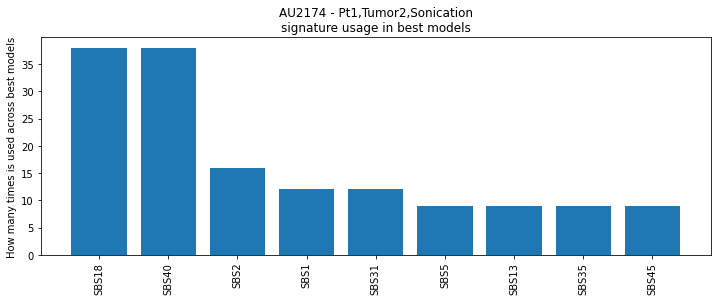

32
(('SBS1', 'SBS2', 'SBS18', 'SBS35', 'SBS40'), array([[ 41.62509191,  88.75942867, 225.76947824,  91.92874281,
        917.34460206]]), 438.80602182086443)


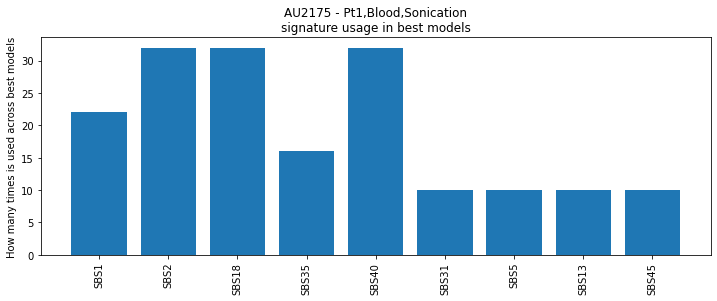

13
(('SBS2', 'SBS5', 'SBS18', 'SBS35', 'SBS40'), array([[ 73.88521603, 478.32361764, 306.48371131, 291.1612853 ,
        832.36820409]]), 497.059758090629)


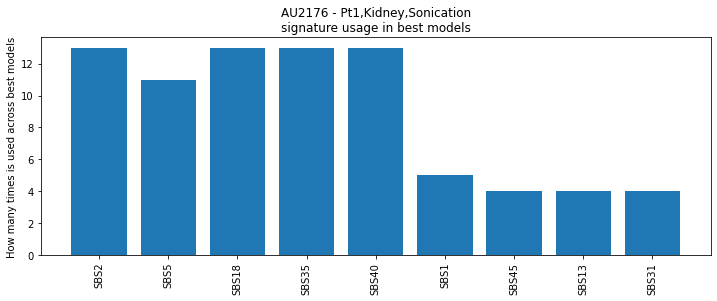

37
(('SBS2', 'SBS18', 'SBS35', 'SBS40'), array([[  84.02544755,  356.48087804,  315.85996146, 1461.81605188]]), 523.1051469869315)


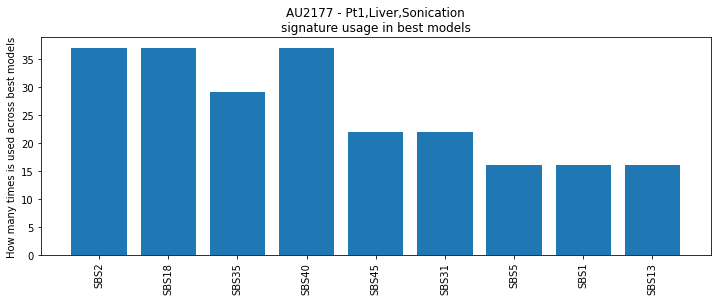

43
(('SBS2', 'SBS5', 'SBS18', 'SBS40', 'SBS45'), array([[ 133.52383613,  273.70637152,  332.72806151, 1047.62813933,
         101.16129328]]), 491.85068544420017)


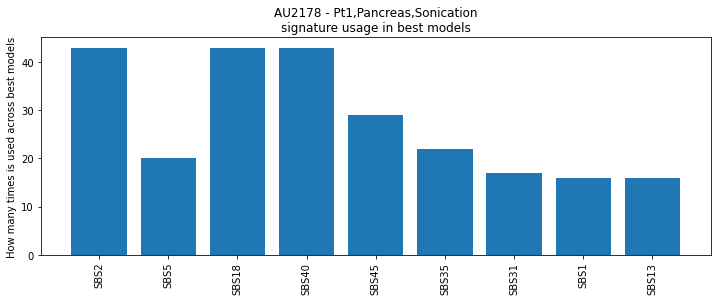

26
(('SBS1', 'SBS5', 'SBS18', 'SBS35', 'SBS40'), array([[ 33.38496099, 441.79994155, 178.56326343, 178.23237317,
        834.02205443]]), 449.5759398197984)


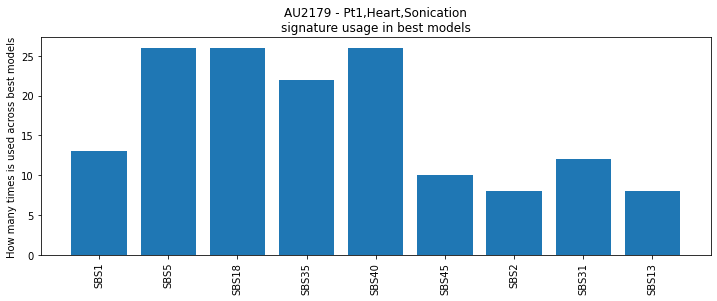

25
(('SBS2', 'SBS18', 'SBS31', 'SBS40', 'SBS45'), array([[1236.97151752, 2112.75053908, 2951.48244683, 1799.13997306,
        2018.77702223]]), 884.958976375124)


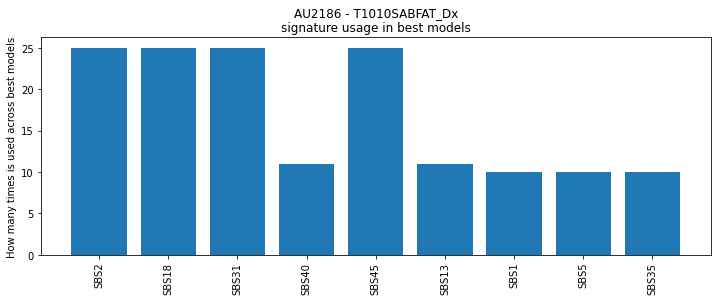

12
(('SBS2', 'SBS18', 'SBS31', 'SBS40', 'SBS45'), array([[ 6806.21956289, 20634.3437995 , 11596.20221144, 22889.74921397,
         6790.96081308]]), 1250.1674246659231)


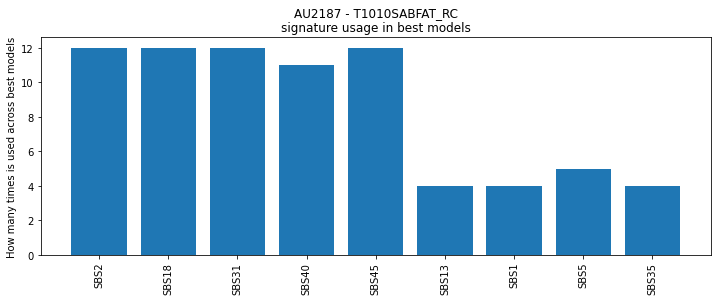

15
(('SBS2', 'SBS18', 'SBS31', 'SBS40', 'SBS45'), array([[18504.93388224, 60871.03573212, 50257.0096491 , 46974.79213357,
        24132.86248243]]), 1420.2906953889665)


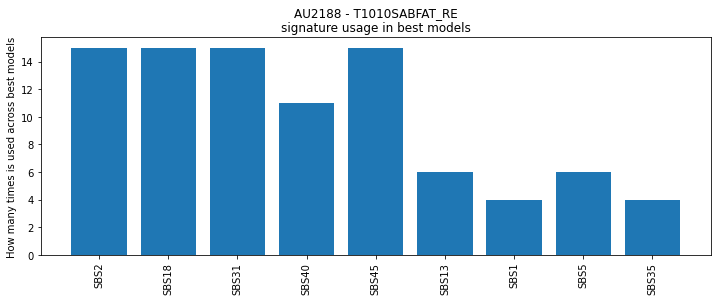

38
(('SBS1', 'SBS31', 'SBS40', 'SBS45'), array([[ 42.48871268, 104.89198864, 889.60060409,  91.87096501]]), 456.2784716112369)


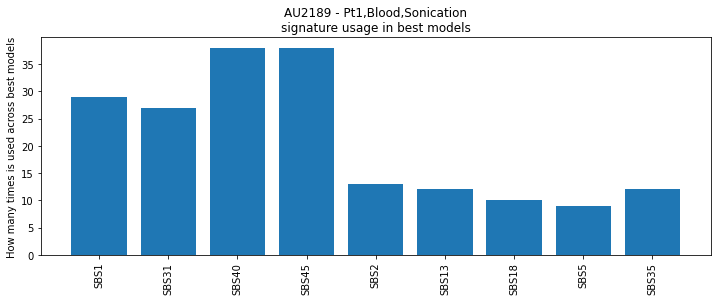

59
(('SBS2', 'SBS18', 'SBS40'), array([[ 17.92706492, 104.87950013, 524.34428382]]), 304.31938582181755)


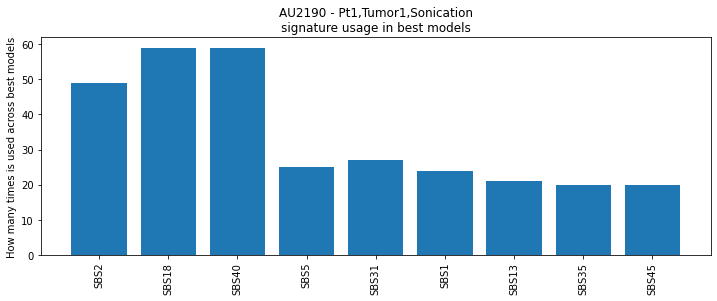

93
(('SBS2', 'SBS40', 'SBS45'), array([[ 39.91648784, 820.3375087 ,  67.21100467]]), 474.48968219085424)


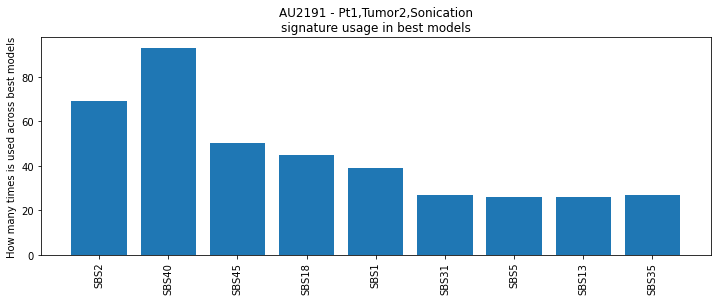

60
(('SBS1', 'SBS2', 'SBS18', 'SBS40', 'SBS45'), array([[ 29.22245959,  15.53745869,  78.27119128, 496.94923925,
         28.013686  ]]), 350.4361353565345)


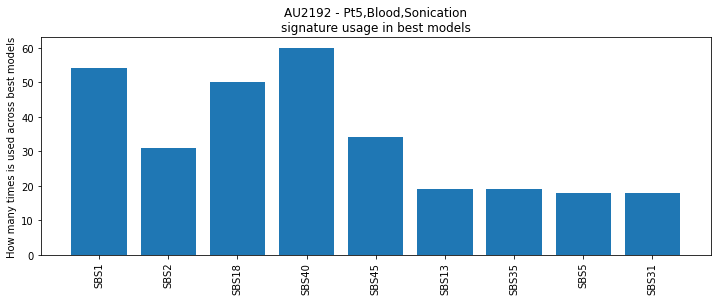

26
(('SBS1', 'SBS2', 'SBS18', 'SBS40'), array([[ 27.4945498 ,  37.04416133, 226.62079395, 604.45238407]]), 379.392598300399)


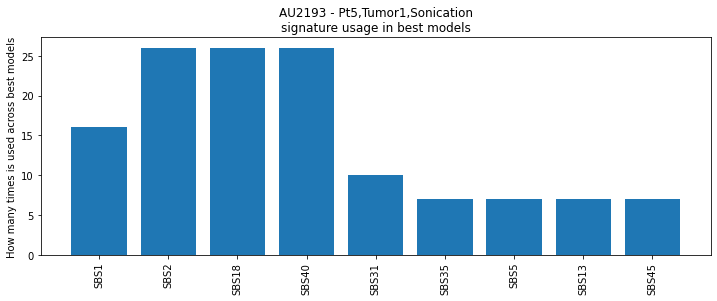

64
(('SBS1', 'SBS2', 'SBS18', 'SBS40', 'SBS45'), array([[ 28.43111812,  40.90655023,  89.81633081, 754.10910589,
         43.89379685]]), 426.6198775172718)


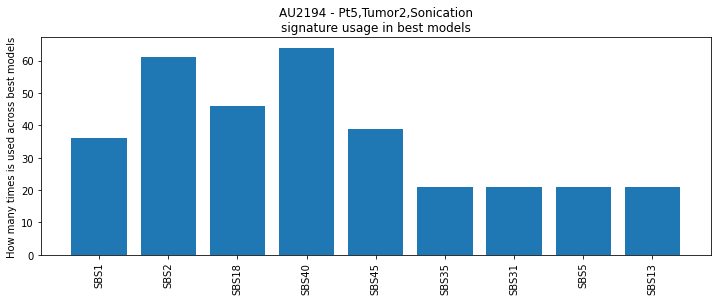

20
(('SBS1', 'SBS2', 'SBS18', 'SBS35', 'SBS40'), array([[  53.34666264,   63.56878249,  226.00780623,  194.23377159,
        1366.12301197]]), 493.92283719605996)


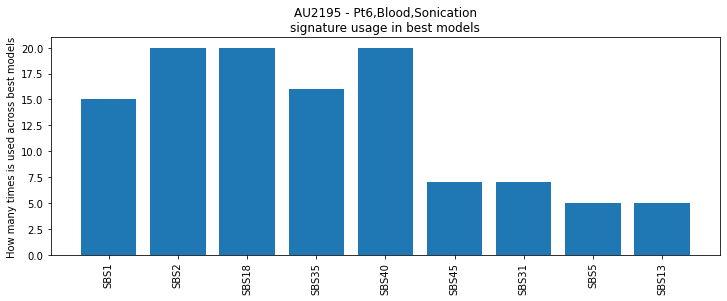

121
(('SBS18', 'SBS40'), array([[130.19838786, 951.19934496]]), 505.352630385303)


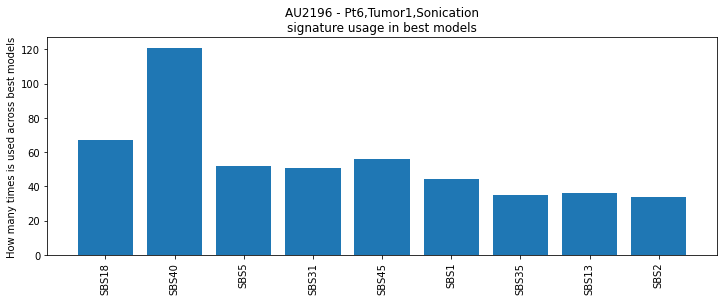

148
(('SBS1', 'SBS2', 'SBS31', 'SBS40', 'SBS45'), array([[ 40.93557269,  45.86265479,  89.68805375, 823.53052443,
         84.87590254]]), 493.9475288097626)


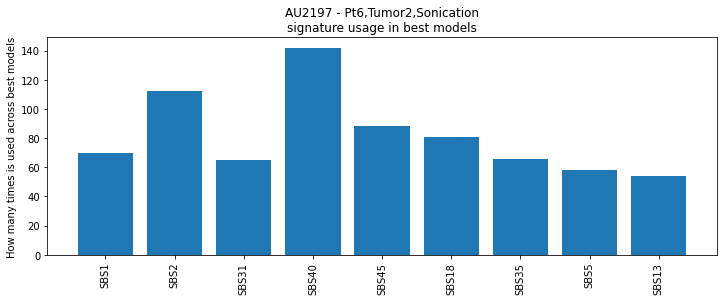

16
(('SBS1', 'SBS2', 'SBS31', 'SBS45'), array([[ 28.42001925,  24.20422157, 257.88514331, 116.633166  ]]), 273.40786315265996)


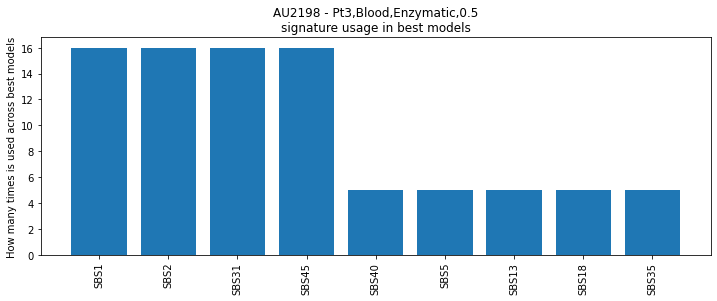

36
(('SBS1', 'SBS2', 'SBS18', 'SBS40', 'SBS45'), array([[ 25.18659049,  53.00198763, 144.20376129, 376.17180052,
         90.76305031]]), 405.3024909609543)


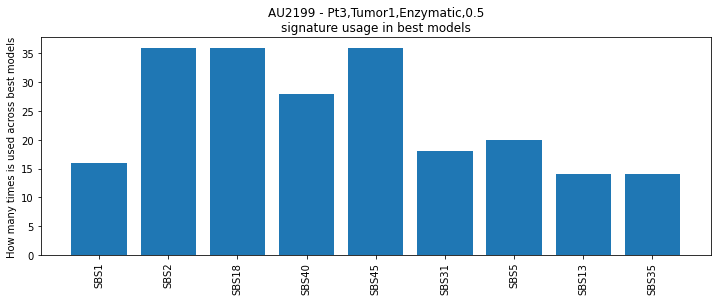

11
(('SBS1', 'SBS2', 'SBS5', 'SBS18', 'SBS31', 'SBS45'), array([[ 18.01590327,  14.08011696, 205.56658342,  63.86490292,
         49.39272304,  54.54528986]]), 252.3498258425181)


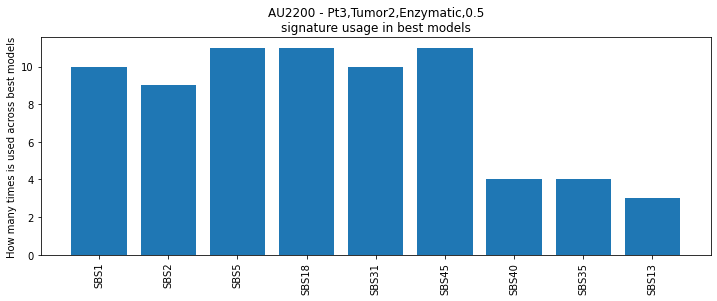

130
(('SBS40', 'SBS45'), array([[133.91745205,  15.99060921]]), 165.41078265470517)


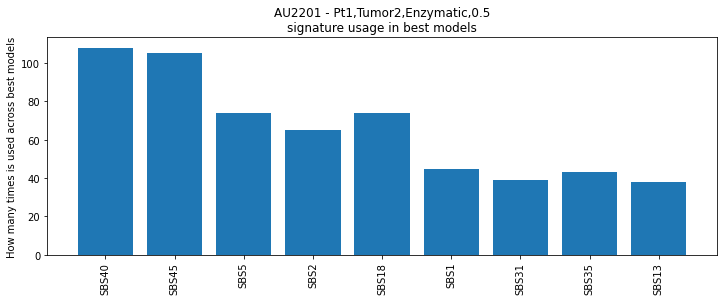

31
(('SBS1', 'SBS2', 'SBS5', 'SBS18', 'SBS31', 'SBS40'), array([[ 8.47546526,  4.78885356, 37.8474552 , 50.63152018, 18.57498508,
        54.23079208]]), 87.77586465457874)


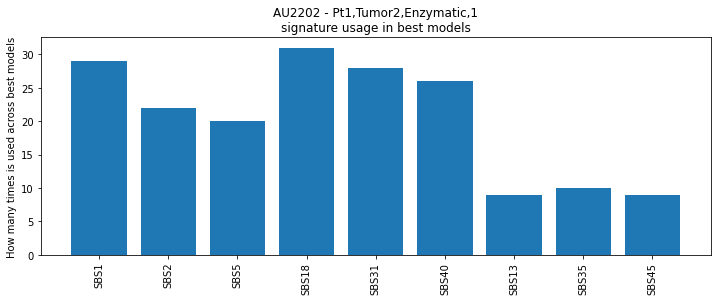

41
(('SBS5', 'SBS18', 'SBS35', 'SBS40'), array([[460.09636299, 133.24678548, 257.71726693, 221.83725971]]), 394.58583520736534)


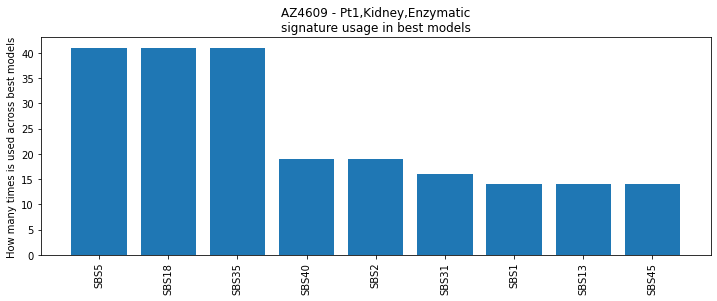

23
(('SBS5', 'SBS31', 'SBS35', 'SBS40', 'SBS45'), array([[324.2457469 , 172.01717092, 141.2550874 , 185.99599281,
         92.45578401]]), 381.7533771089935)


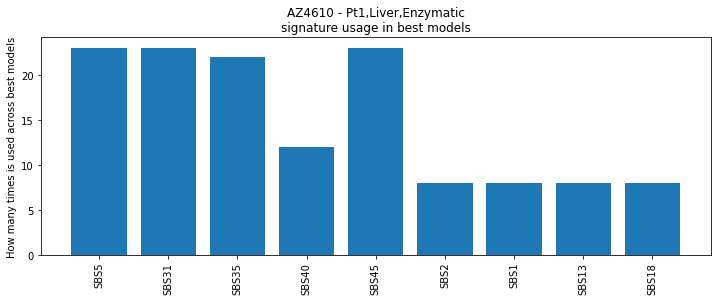

37
(('SBS5', 'SBS31', 'SBS40', 'SBS45'), array([[104.5908668 , 106.05048863, 199.11907973,  53.13991338]]), 249.39605760233596)


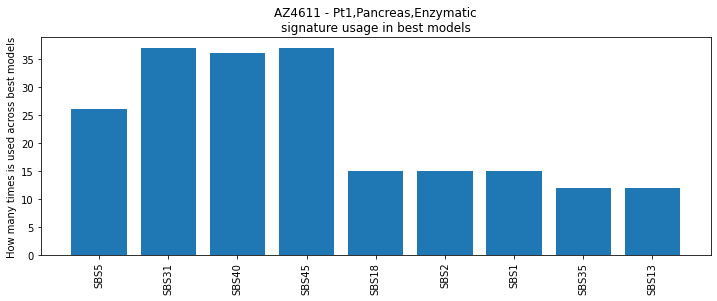

112
(('SBS1', 'SBS31', 'SBS35', 'SBS40'), array([[ 27.31107206,  66.03072698,  94.75076944, 582.76068987]]), 392.50512450890875)


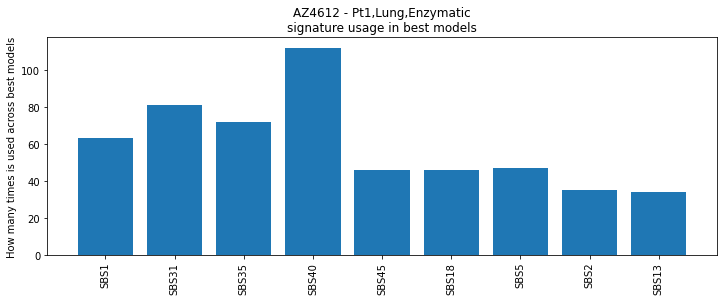

69
(('SBS2', 'SBS13', 'SBS31', 'SBS40'), array([[ 19.53883754,  15.50370449,  63.67193973, 269.73753192]]), 283.4558790553941)


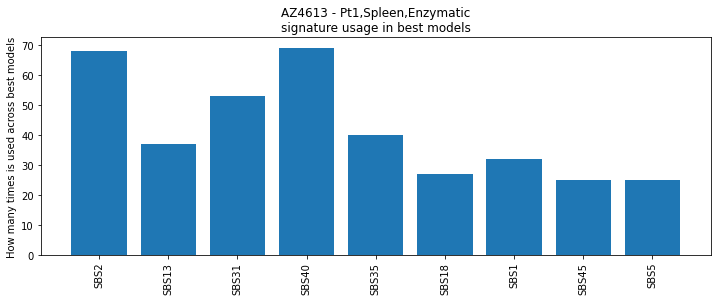

51
(('SBS5', 'SBS18', 'SBS35', 'SBS40'), array([[ 81.15094186,  37.00778349,  68.11786198, 130.3660871 ]]), 193.55125525965494)


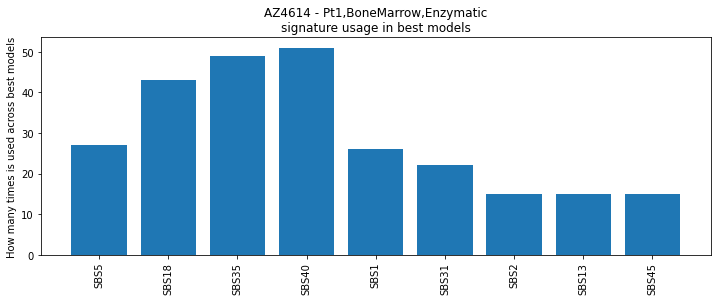

60
(('SBS5', 'SBS18', 'SBS35'), array([[101.83416114,  26.67047148,  25.60219986]]), 115.928303489254)


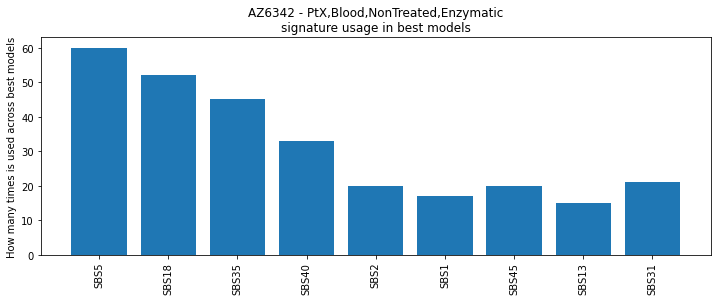

47
(('SBS31', 'SBS40'), array([[17.11064956, 37.64551196]]), 24.49923361168312)


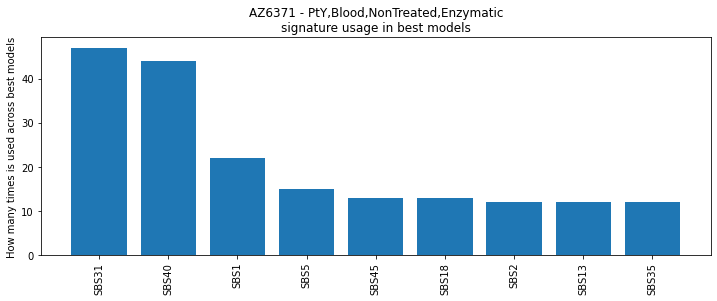

In [207]:
best_models_dict = {}
for sample_id in sample_ids:
    sample_type = sample_dict[sample_id]
    tumor2_list = sorted(res_dict[sample_id],key=lambda x:x[2])
    aic_min=tumor2_list[0][2]
    res_sample = [item for item in tumor2_list if item[2] - aic_min <= 5]
    print(len(res_sample))
    print(res_sample[0])
    sorted_best_models = best_models(sample_id+' - '+sample_type,res_sample)
    best_models_dict[sample_id] = sorted_best_models

### Show most frequent combinations

In [208]:
import itertools as itt

In [209]:
def best_sig_combinations (sample_ids, sample_dict,res_dict,num_sigs):
    best_models_dict = {}
    for sample_id in sample_ids:
        sample_type = sample_dict[sample_id]
        tumor2_list = sorted(res_dict[sample_id],key=lambda x:x[2])
        aic_min=tumor2_list[0][2]
        res_sample = [item for item in tumor2_list if item[2] - aic_min <= 5]

        good_sets = [set(r[0]) for r in res_sample]
        freq_dict = {}
        for item in itt.combinations(candidate_signatures, num_sigs):
            freq = 0
            for good_set in good_sets:
                s = set(item)
                if s.issubset(good_set):
                    freq += 1
            freq_dict[item] = freq
        freq_sorted = sorted(freq_dict.items(), key=lambda x:x[1],reverse=True)
        freq_sorted2 = [(f[0],f[1]) for f in freq_sorted if f[1]>=5]
        freq_sorted_dict = dict(freq_sorted2)
        if len(freq_sorted_dict)>50:
            selected_keys = list(freq_sorted_dict.keys())
            selected_keys = selected_keys[0:50]
            freq_sorted_dict = {k:v for k,v in freq_sorted_dict.items() if k in selected_keys}
        plt.figure(figsize = (12,4))
        plt.bar(range(len(freq_sorted_dict)),list(freq_sorted_dict.values()),align='center')
        plt.xticks(range(len(freq_sorted_dict)), list(freq_sorted_dict.keys()),rotation=90)
        plt.title(sample_id +' '+sample_type+ ' '+str(num_sigs)+' signatures')
        plt.show()

In [210]:
selected_sample_ids = ['AU2198',
 'AU2199',
 'AU2200',
 'AU2201',
 'AU2202',
 'AZ4609',
 'AZ4610',
 'AZ4611',
 'AZ4612',
 'AZ4613',
 'AZ4614',
 'AZ6342',
 'AZ6371']

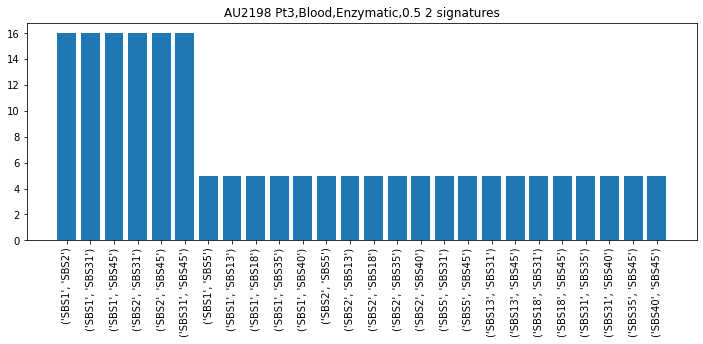

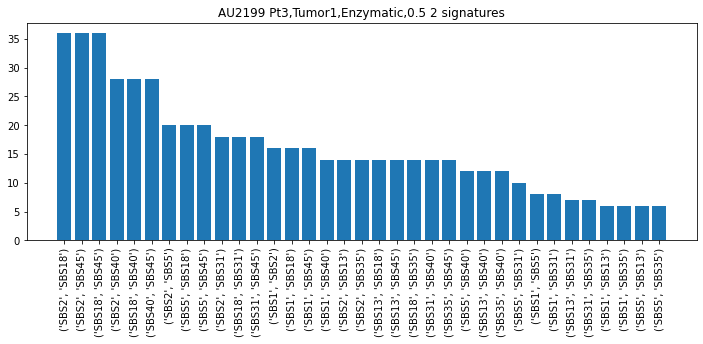

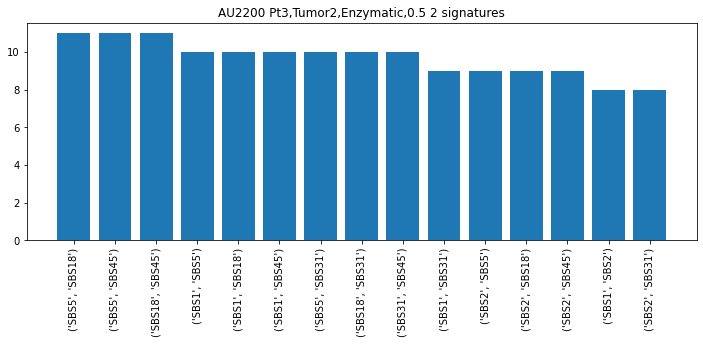

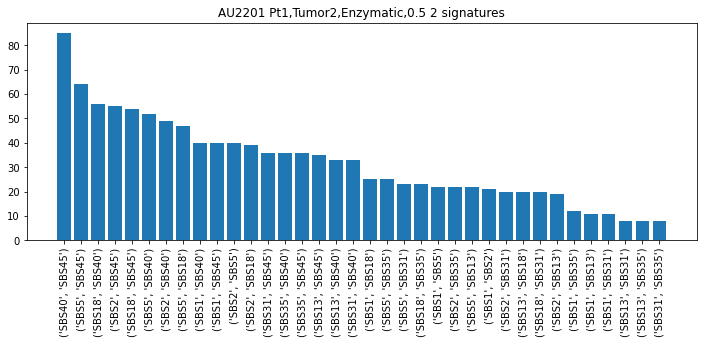

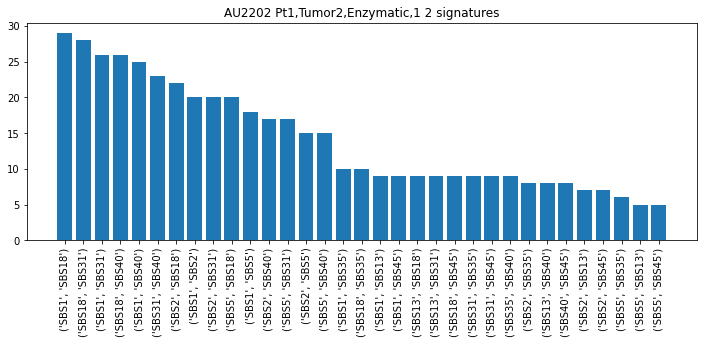

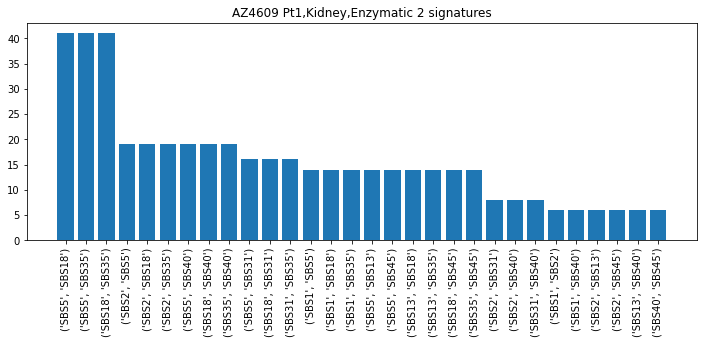

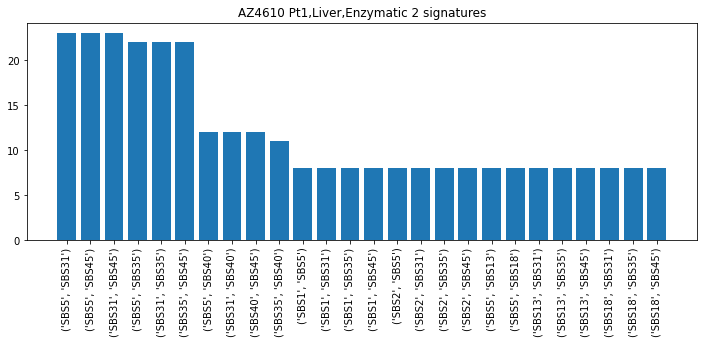

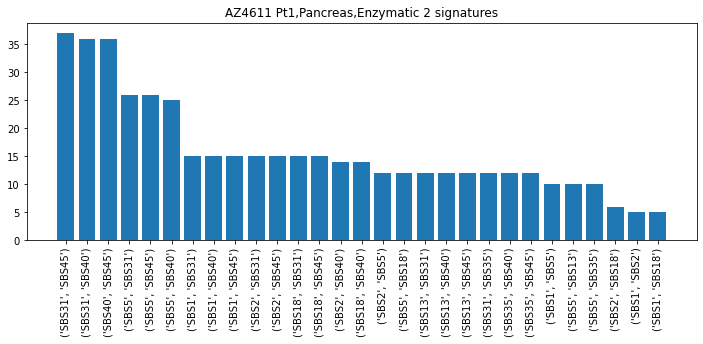

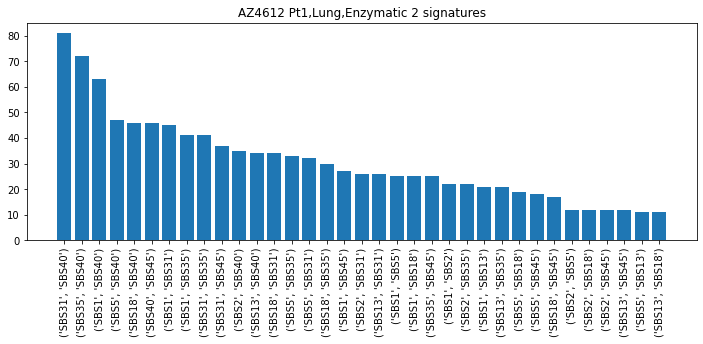

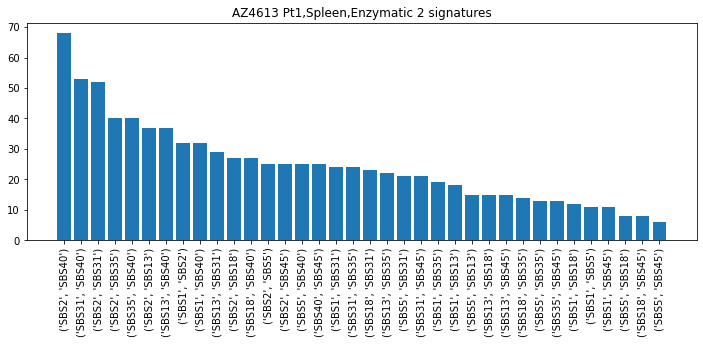

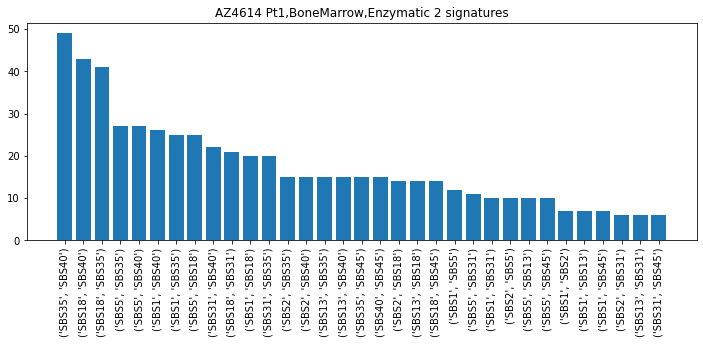

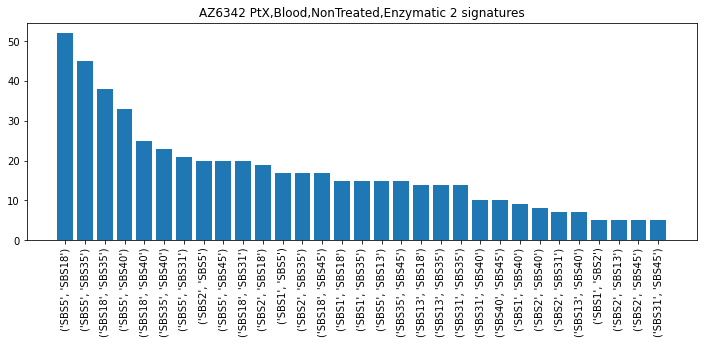

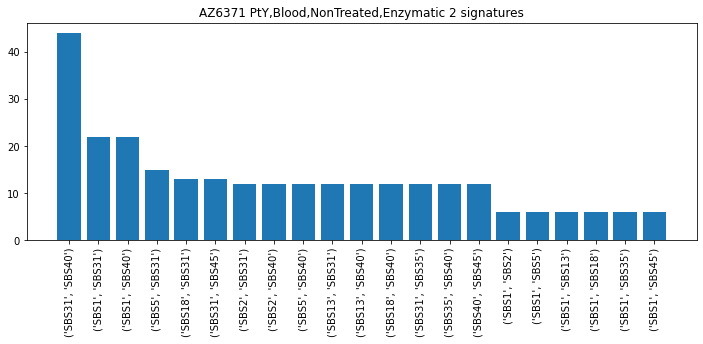

In [211]:
num_sigs = 2
best_sig_combinations (selected_sample_ids, sample_dict,res_dict,num_sigs)

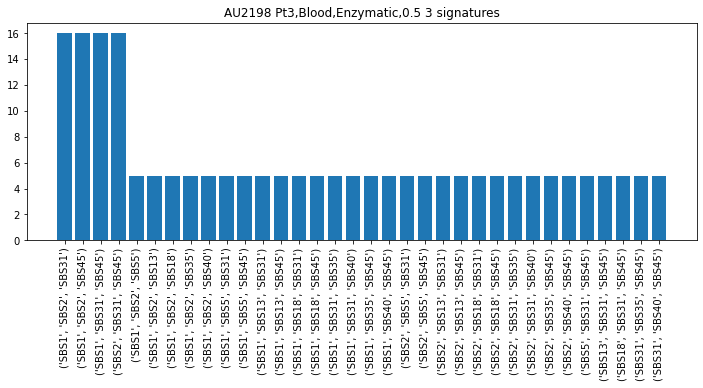

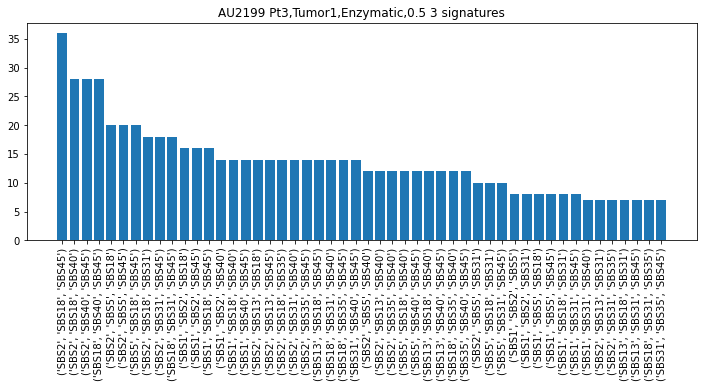

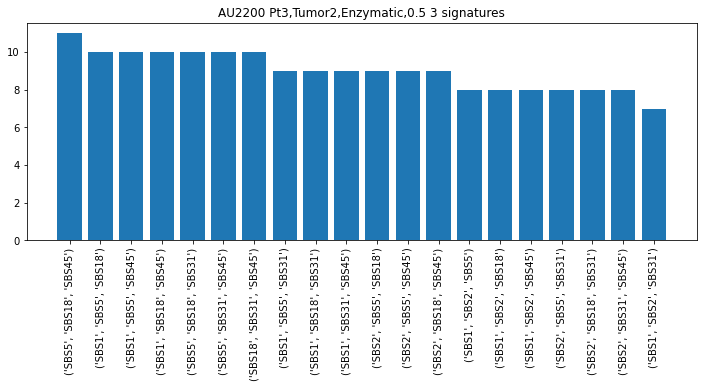

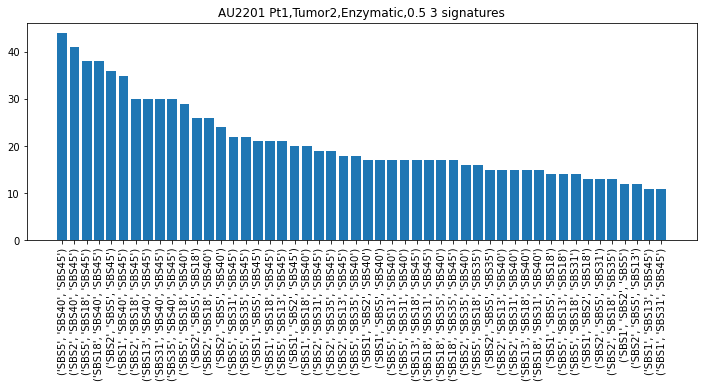

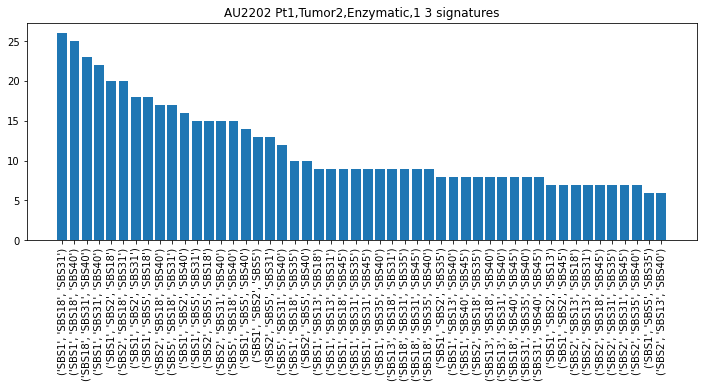

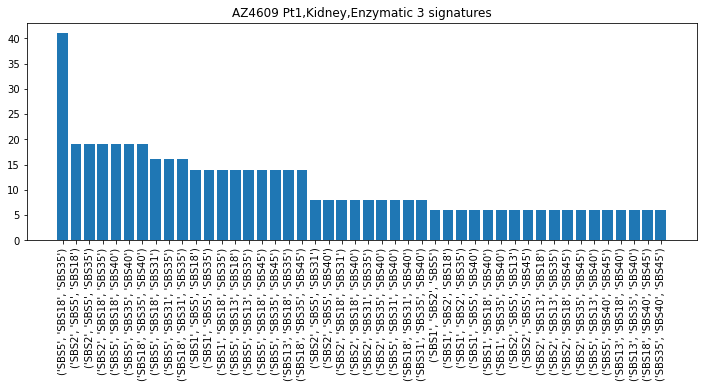

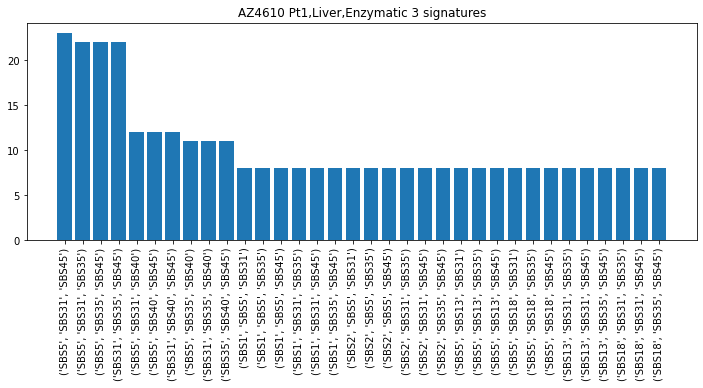

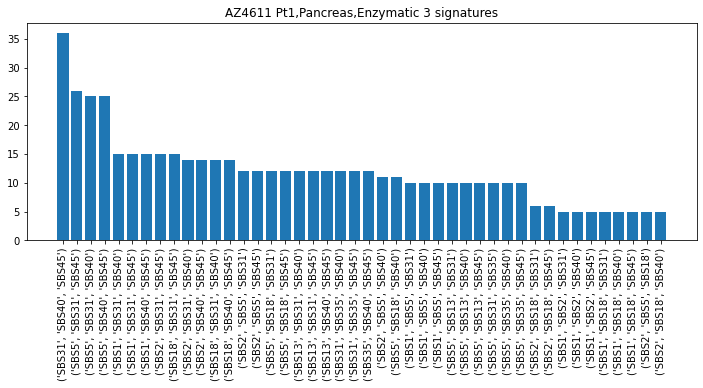

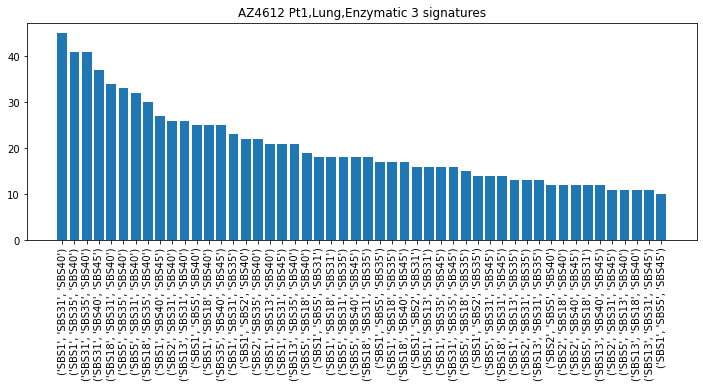

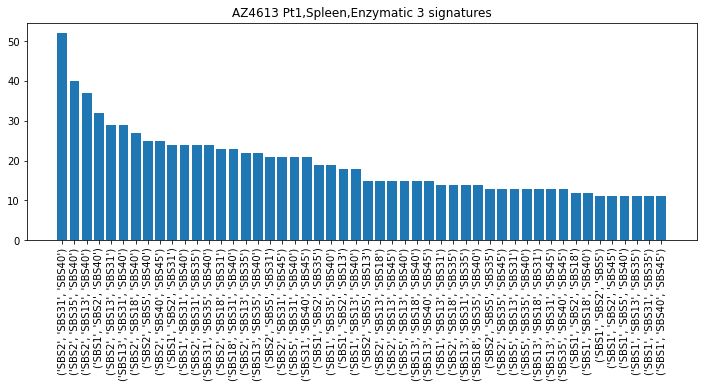

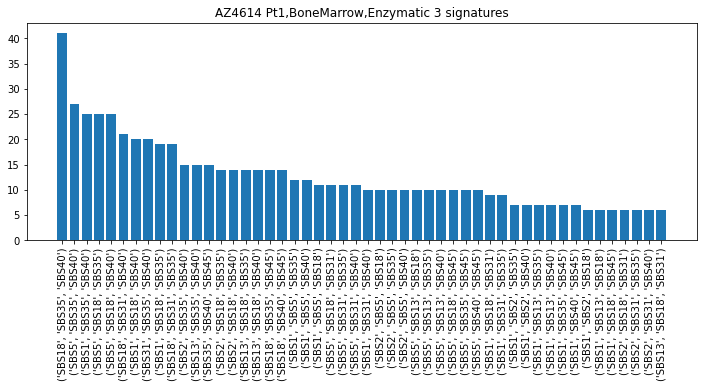

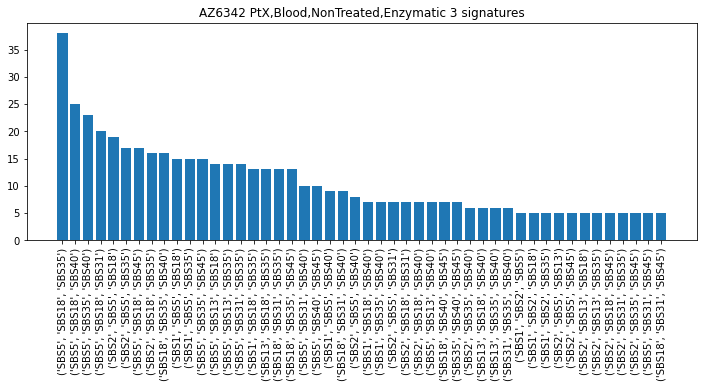

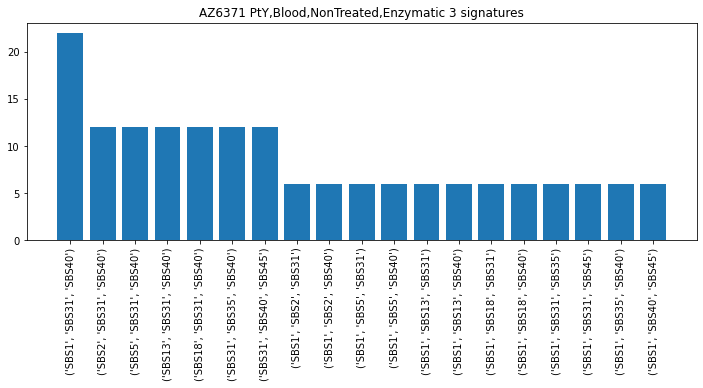

In [212]:
num_sigs = 3
best_sig_combinations (selected_sample_ids, sample_dict,res_dict,num_sigs)

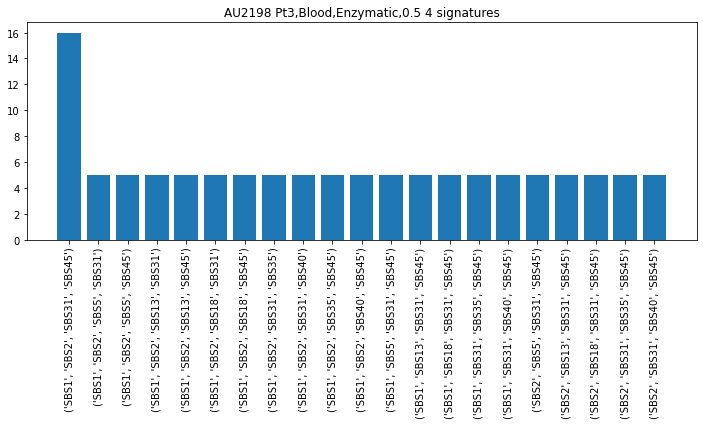

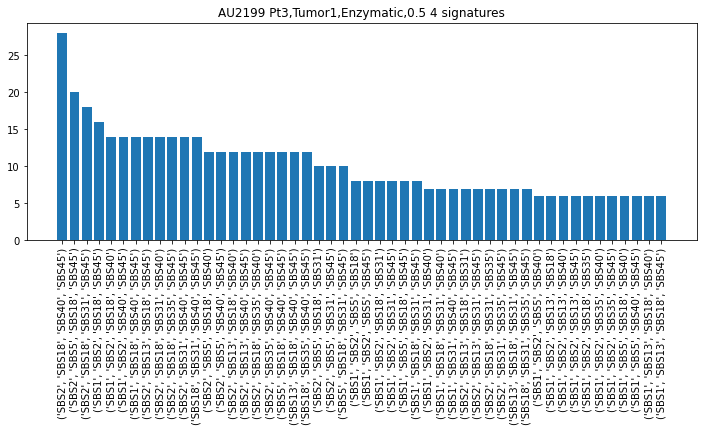

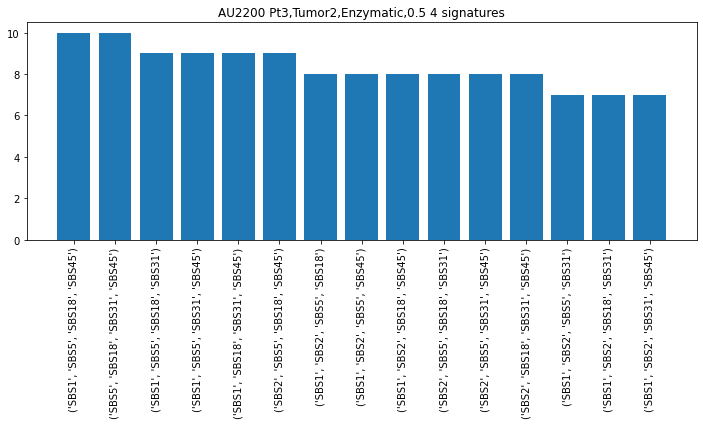

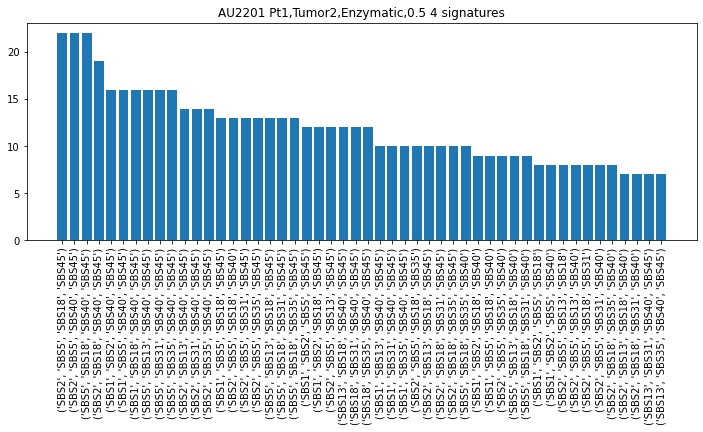

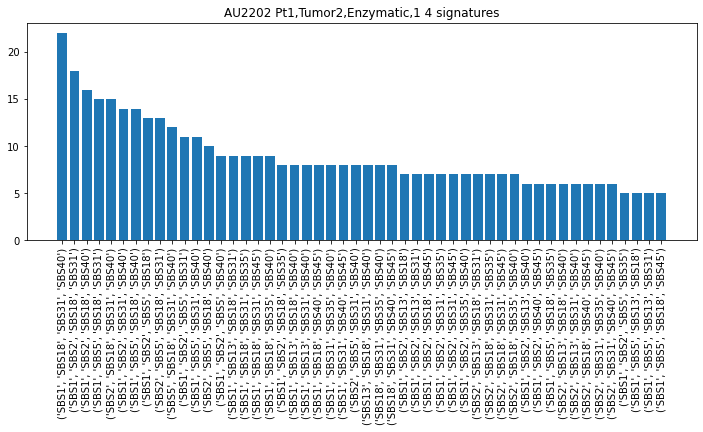

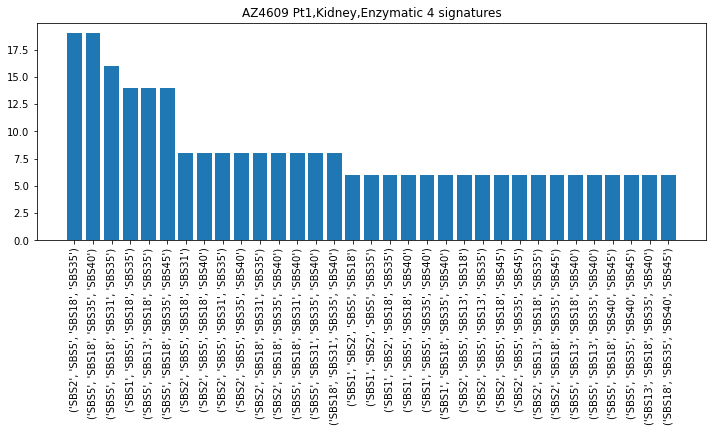

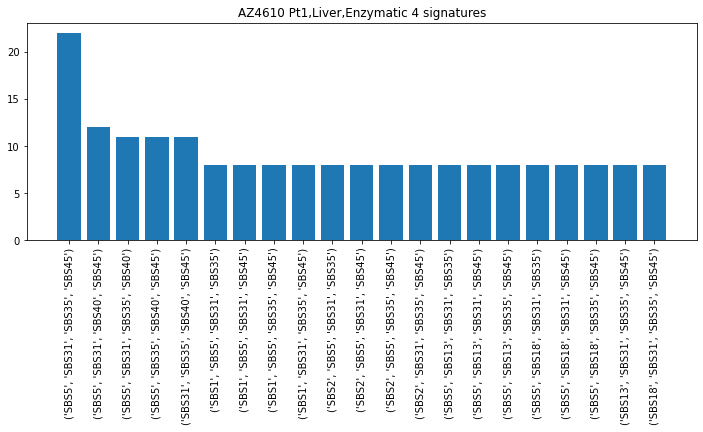

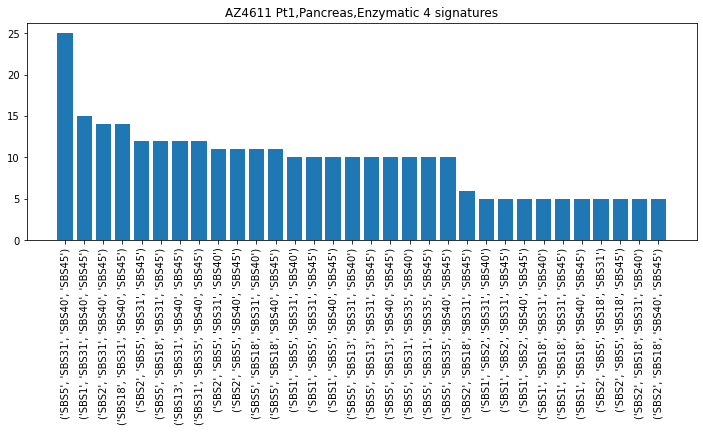

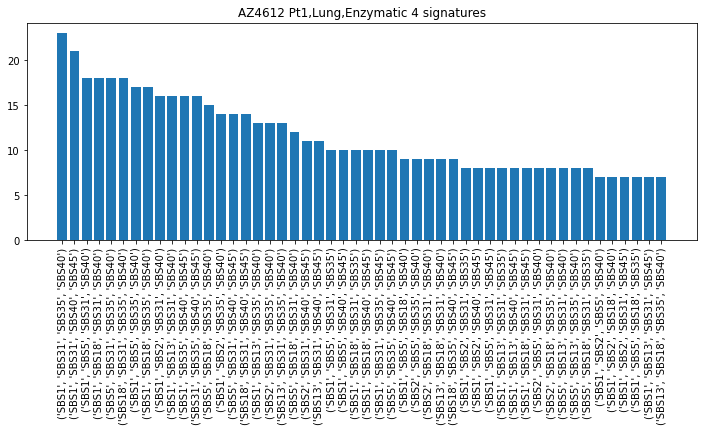

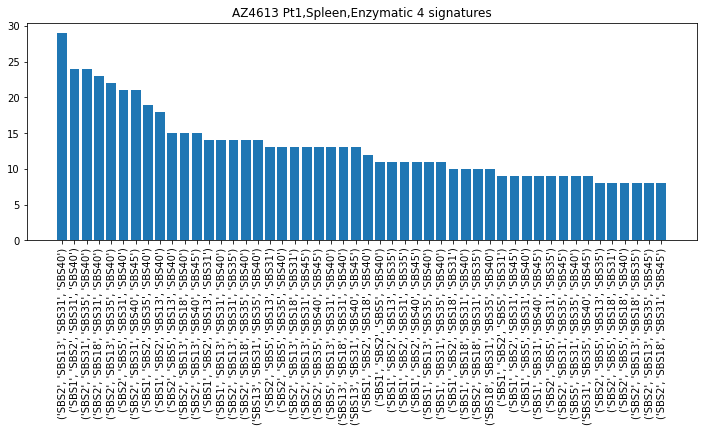

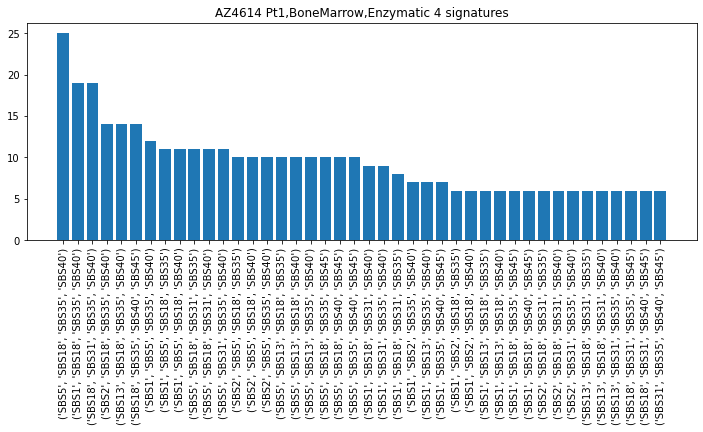

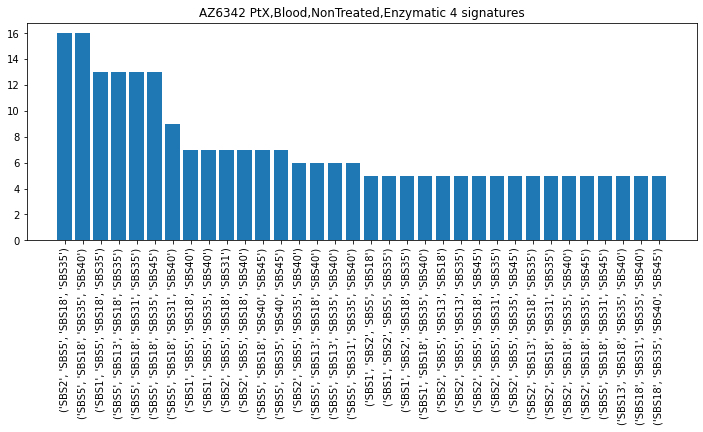

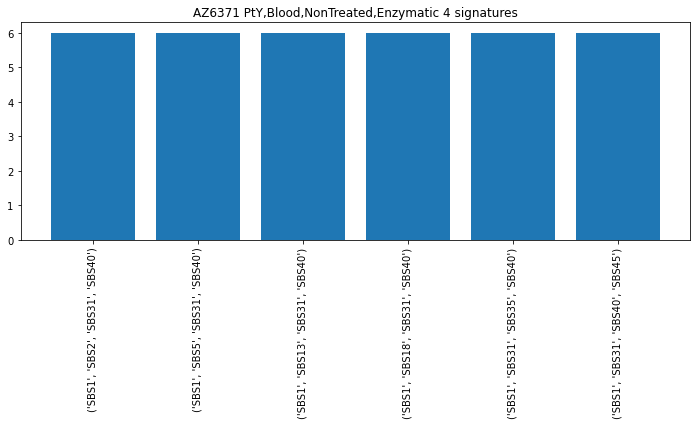

In [213]:
num_sigs = 4
best_sig_combinations (selected_sample_ids, sample_dict,res_dict,num_sigs)

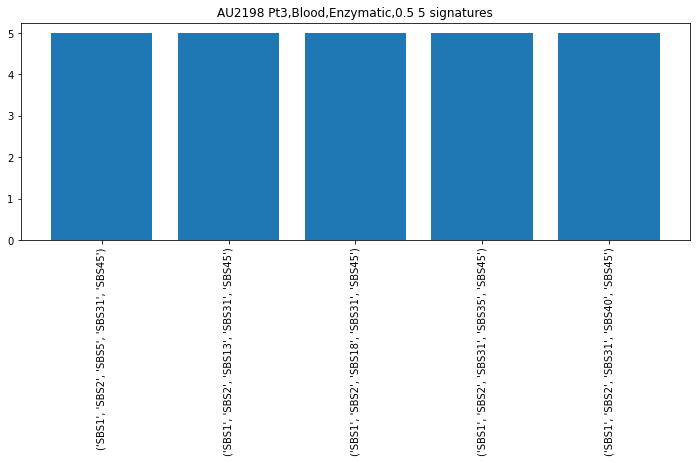

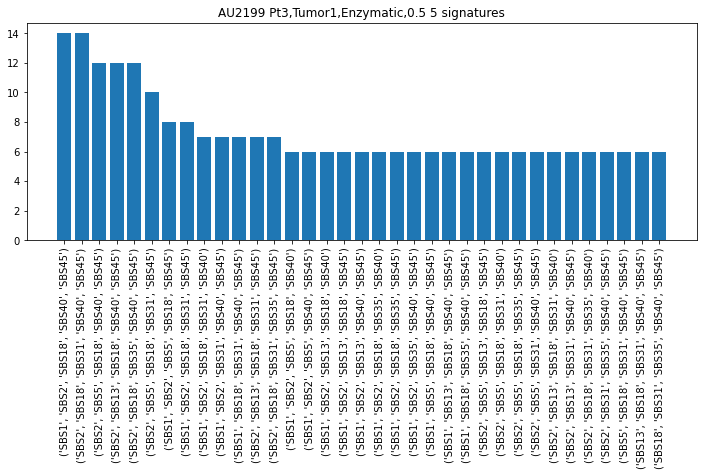

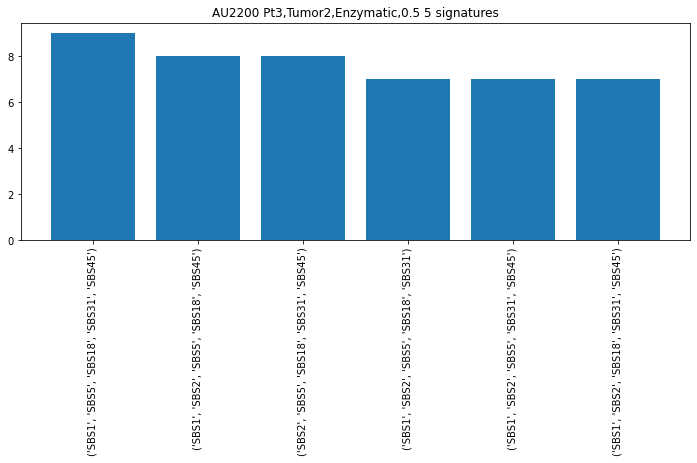

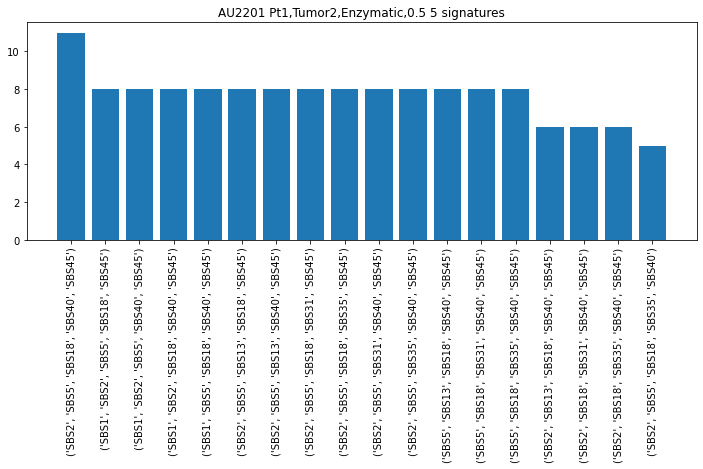

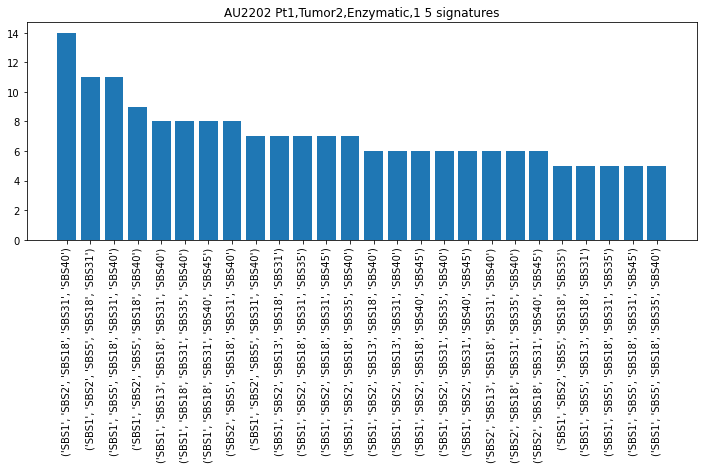

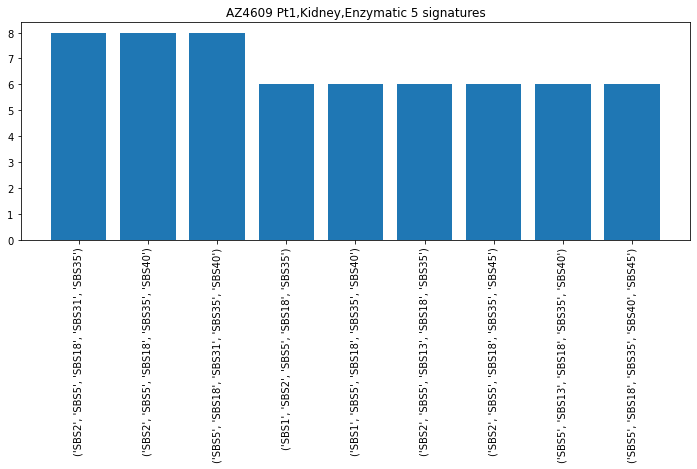

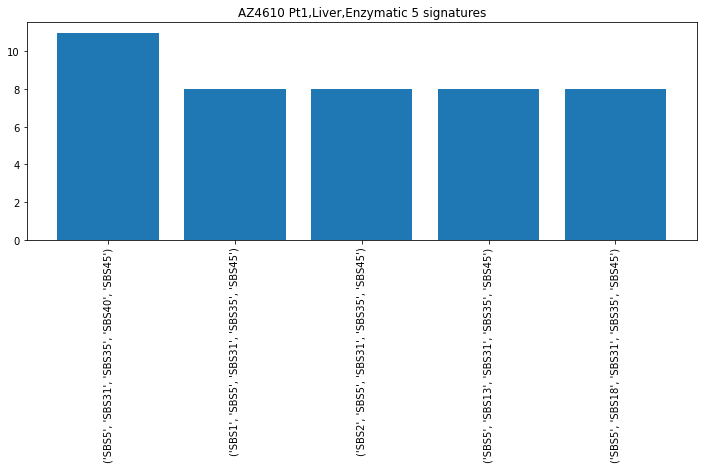

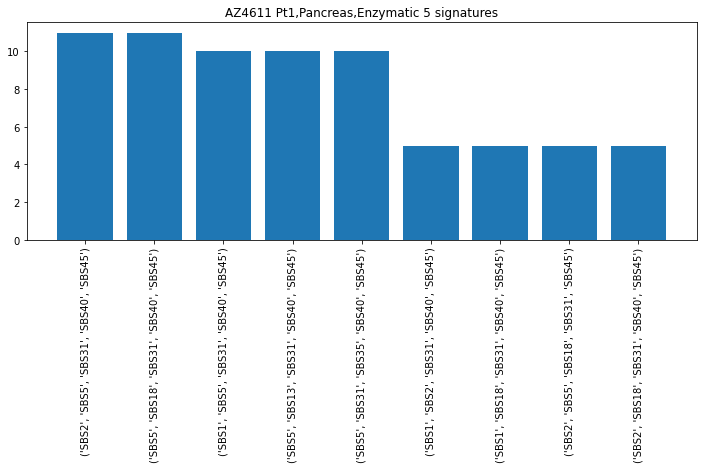

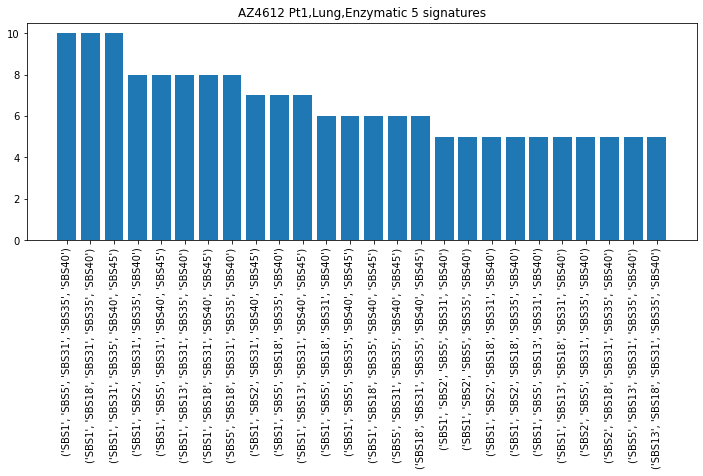

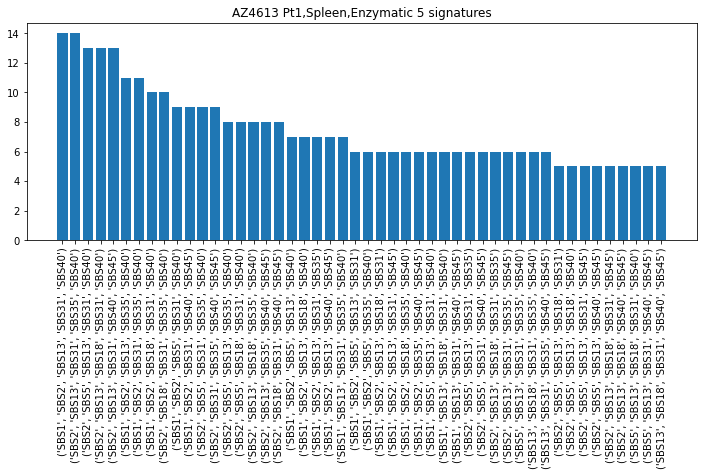

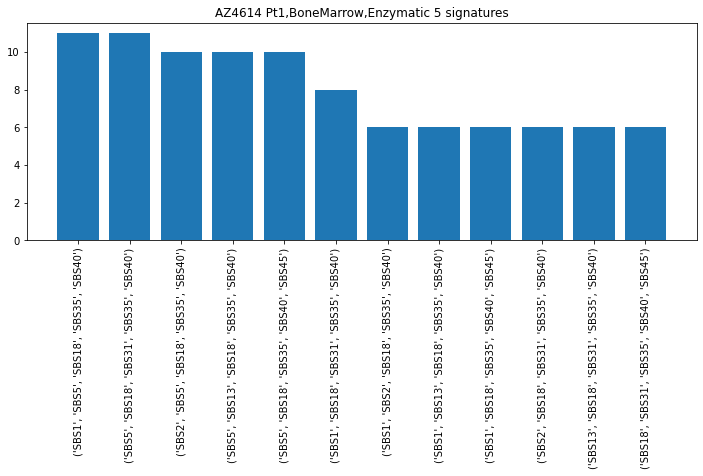

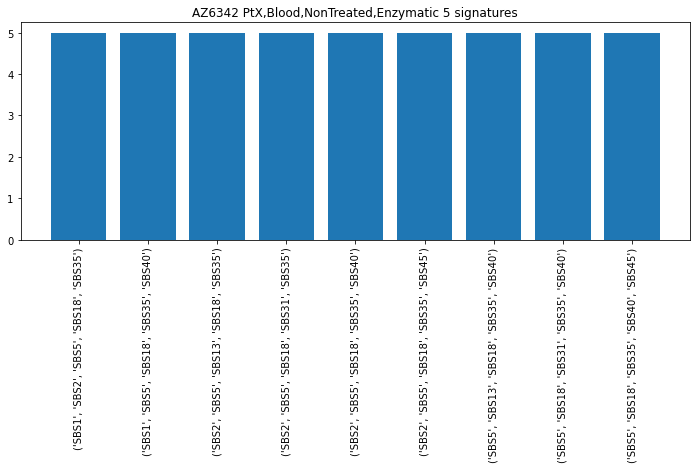

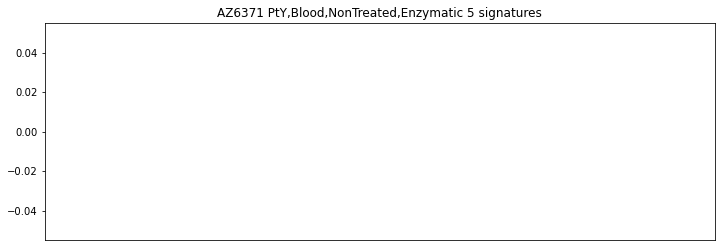

In [214]:
num_sigs = 5
best_sig_combinations (selected_sample_ids, sample_dict,res_dict,num_sigs)

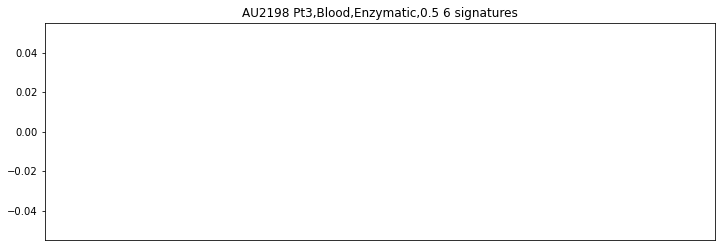

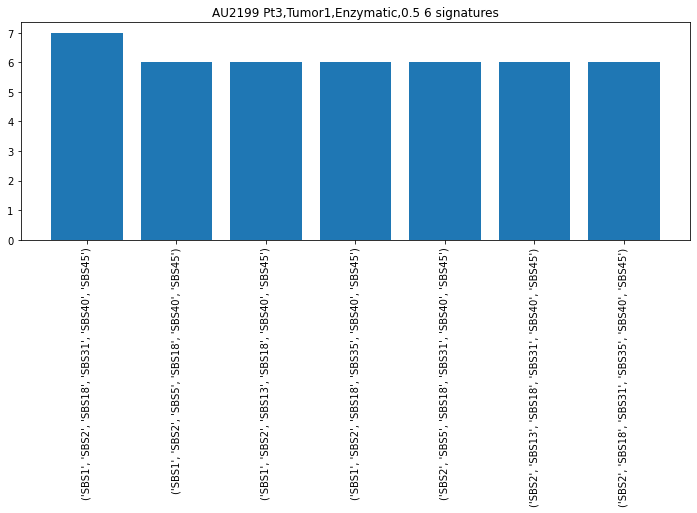

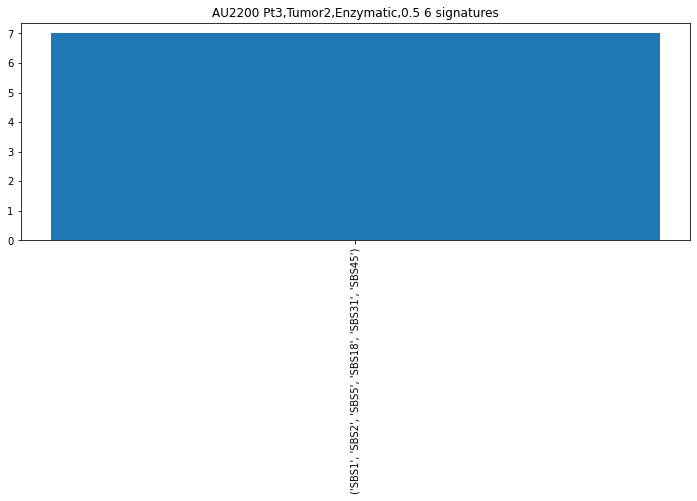

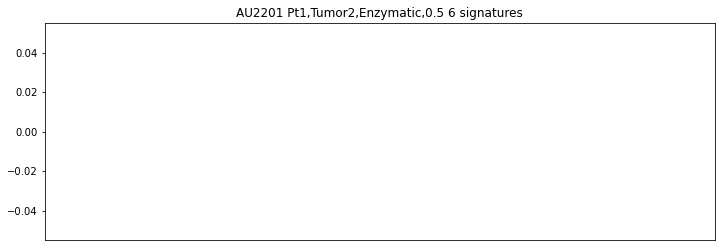

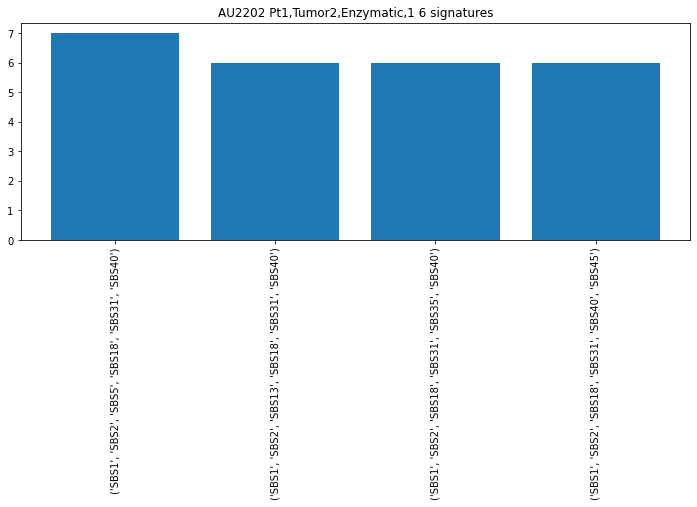

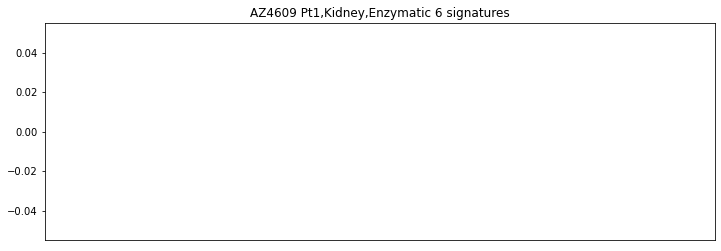

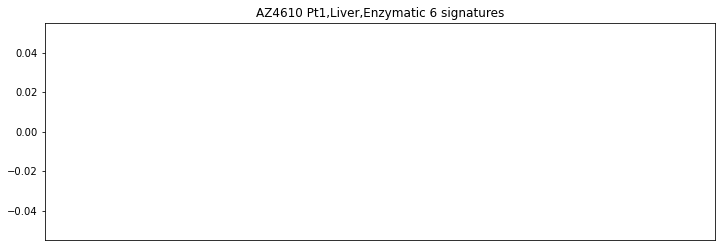

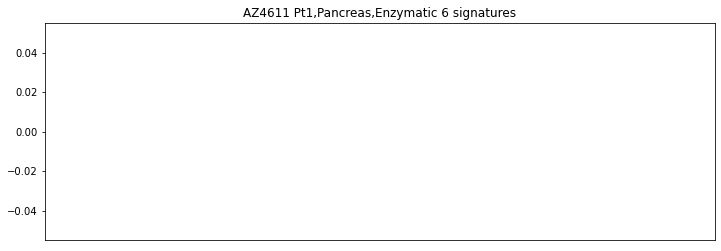

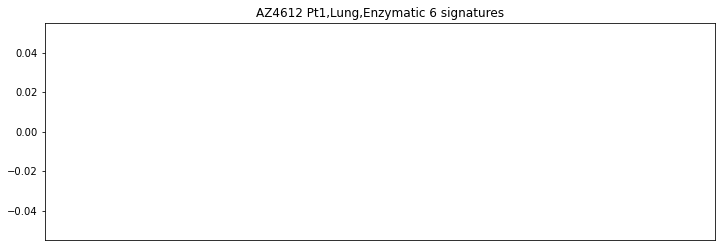

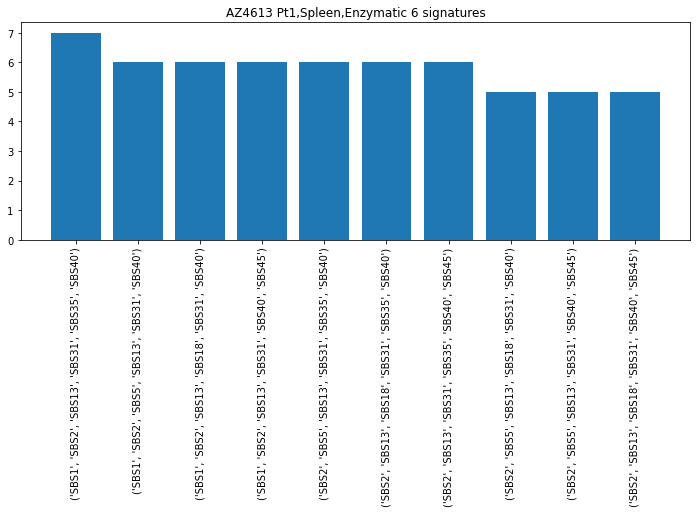

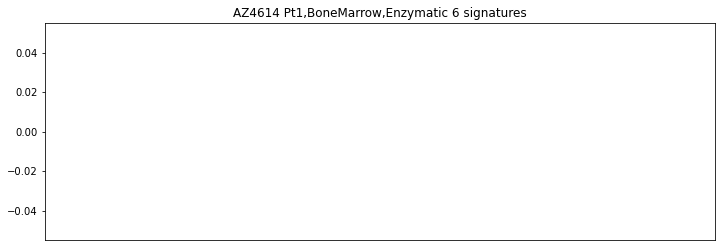

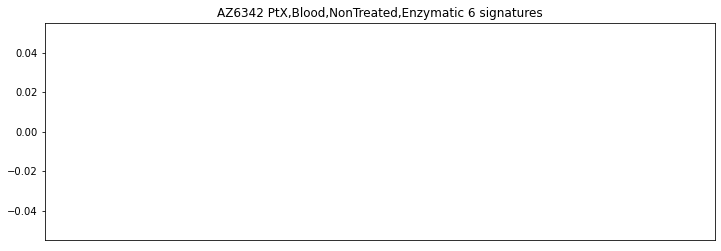

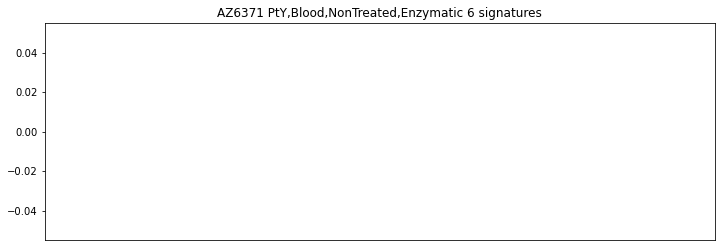

In [215]:
num_sigs = 6
best_sig_combinations (selected_sample_ids, sample_dict,res_dict,num_sigs)

In [216]:
def check_aic (sample_id,signatures):
    tumor2_list = sorted(res_dict[sample_id],key=lambda x:x[2])
    aic_min=tumor2_list[0][2]
#     res_sample = [item for item in tumor2_list if item[2] - aic_min <= 5]
    res_sample = res_dict[sample_id]
    [ print((sample_id,r[0],'aic_min distance:',round((r[2]-aic_min),3))) for r in res_sample if r[0]==signatures]

In [217]:
#selection based on the analysis from the re-aclulated counts
selected_sigs_dict = {'AU2198':['SBS1','SBS2','SBS31','SBS45'],
                       'AU2199':['SBS1','SBS2','SBS18','SBS31','SBS40','SBS45'],
                       'AU2200':['SBS1','SBS2','SBS5','SBS18','SBS31','SBS45'],
                       'AU2202':['SBS1','SBS2','SBS18','SBS31','SBS40'],
                       'AZ4609':['SBS5','SBS18','SBS31','SBS40','SBS45'],
                       'AZ4610':['SBS5','SBS31','SBS40','SBS45'],
                       'AZ4611':['SBS5','SBS31','SBS40','SBS45'],
                       'AZ4612':['SBS1','SBS31','SBS40'],
                       'AZ4613':['SBS2','SBS13','SBS31','SBS40'],
                       'AZ4614':['SBS5','SBS18','SBS31','SBS40'],
                       'AZ6342':['SBS5','SBS18','SBS31','SBS40'],
                       'AZ6371':['SBS1','SBS18','SBS31','SBS40']
                      }
for sample_id in selected_sigs_dict.keys():
    signatures = tuple(selected_sigs_dict[sample_id])
    check_aic (sample_id,signatures)

('AU2198', ('SBS1', 'SBS2', 'SBS31', 'SBS45'), 'aic_min distance:', 0.0)
('AU2199', ('SBS1', 'SBS2', 'SBS18', 'SBS31', 'SBS40', 'SBS45'), 'aic_min distance:', 0.095)
('AU2200', ('SBS1', 'SBS2', 'SBS5', 'SBS18', 'SBS31', 'SBS45'), 'aic_min distance:', 0.0)
('AU2202', ('SBS1', 'SBS2', 'SBS18', 'SBS31', 'SBS40'), 'aic_min distance:', 0.695)
('AZ4609', ('SBS5', 'SBS18', 'SBS31', 'SBS40', 'SBS45'), 'aic_min distance:', 14.043)
('AZ4610', ('SBS5', 'SBS31', 'SBS40', 'SBS45'), 'aic_min distance:', 3.719)
('AZ4611', ('SBS5', 'SBS31', 'SBS40', 'SBS45'), 'aic_min distance:', 0.0)
('AZ4612', ('SBS1', 'SBS31', 'SBS40'), 'aic_min distance:', 0.953)
('AZ4613', ('SBS2', 'SBS13', 'SBS31', 'SBS40'), 'aic_min distance:', 0.0)
('AZ4614', ('SBS5', 'SBS18', 'SBS31', 'SBS40'), 'aic_min distance:', 5.552)
('AZ6342', ('SBS5', 'SBS18', 'SBS31', 'SBS40'), 'aic_min distance:', 3.325)
('AZ6371', ('SBS1', 'SBS18', 'SBS31', 'SBS40'), 'aic_min distance:', 2.74)


In [173]:
file = '/workspace/projects/sjd_pediatric_tumors/twinstrand_analysis/20230414_all_samples/signatures/msigact/sigs_from_combinatorial_refitting_curated_recalculated_counts/sigs_per_sample_curated_recalculated_counts.json'
json.dump(selected_sigs_dict,open(file,'w'))

In [163]:
#selection based on the analysis from counts from mutational profile from dnanexus report
selected_sigs_dict = {'AU2198':['SBS1','SBS31','SBS45'],
                       'AU2199':['SBS1','SBS2','SBS18','SBS31'],
                       'AU2200':['SBS1','SBS2','SBS5','SBS31'],
                       'AU2202':['SBS1','SBS5','SBS18','SBS31'],
                       'AZ4609':['SBS5','SBS18','SBS31'],
                       'AZ4610':['SBS5','SBS31','SBS45'],
                       'AZ4611':['SBS1','SBS31','SBS40'],
                       'AZ4612':['SBS1','SBS2','SBS5','SBS31','SBS40'],
                       'AZ4613':['SBS1','SBS2','SBS13','SBS31','SBS40'],
                       'AZ4614':['SBS1','SBS5','SBS18','SBS31'],
                       'AZ6342':['SBS1','SBS5','SBS31'],
                       'AZ6371':['SBS1','SBS5','SBS31']
                      }
for sample_id in selected_sigs_dict.keys():
    signatures = tuple(selected_sigs_dict[sample_id])
    check_aic (sample_id,signatures)

('AU2198', ('SBS1', 'SBS31', 'SBS45'), 'aic_min distance:', 11.255)
('AU2199', ('SBS1', 'SBS2', 'SBS18', 'SBS31'), 'aic_min distance:', 18.303)
('AU2200', ('SBS1', 'SBS2', 'SBS5'), 'aic_min distance:', 53.153)
('AU2202', ('SBS1', 'SBS5', 'SBS18', 'SBS31'), 'aic_min distance:', 5.535)
('AZ4609', ('SBS5', 'SBS18', 'SBS31'), 'aic_min distance:', 18.118)
('AZ4610', ('SBS5', 'SBS31', 'SBS45'), 'aic_min distance:', 6.136)
('AZ4611', ('SBS1', 'SBS31', 'SBS40'), 'aic_min distance:', 18.546)
('AZ4612', ('SBS1', 'SBS2', 'SBS5', 'SBS31', 'SBS40'), 'aic_min distance:', 4.953)
('AZ4613', ('SBS1', 'SBS2', 'SBS13', 'SBS31', 'SBS40'), 'aic_min distance:', 0.802)
('AZ4614', ('SBS1', 'SBS5', 'SBS18', 'SBS31'), 'aic_min distance:', 16.483)
('AZ6342', ('SBS1', 'SBS5', 'SBS31'), 'aic_min distance:', 17.092)
('AZ6371', ('SBS1', 'SBS5', 'SBS31'), 'aic_min distance:', 5.423)


In [131]:
file = '/workspace/projects/sjd_pediatric_tumors/twinstrand_analysis/20230414_all_samples/signatures/msigact/sigs_from_combinatorial_refitting_curated_recalculated_counts/sigs_per_sample_curated_recalculated_counts.json'
json.dump(selected_sigs_dict,open(file,'w'))

### Select signatures from the 3 best models

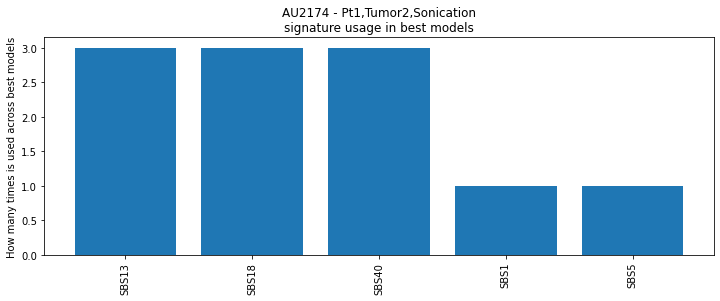

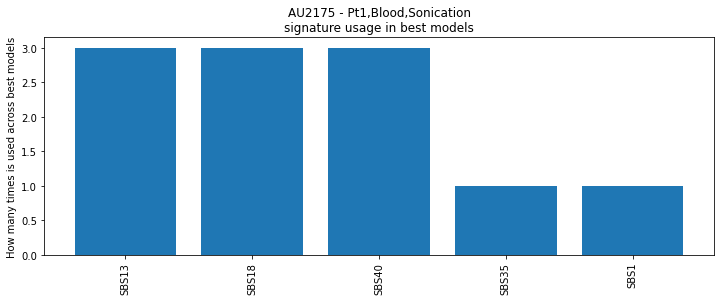

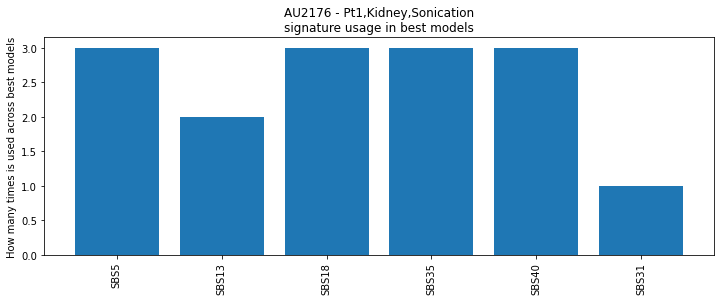

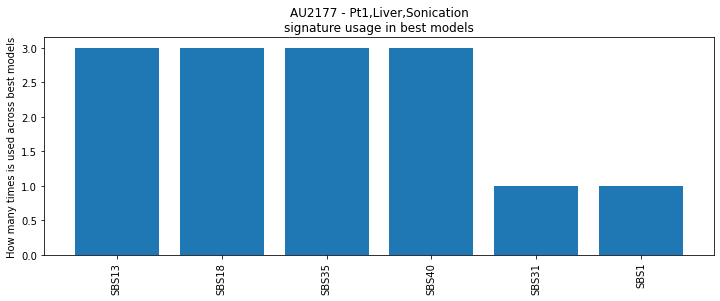

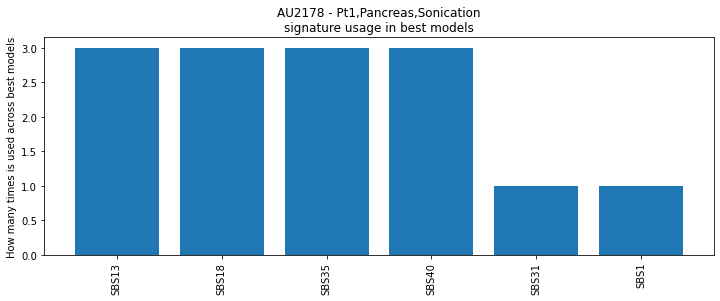

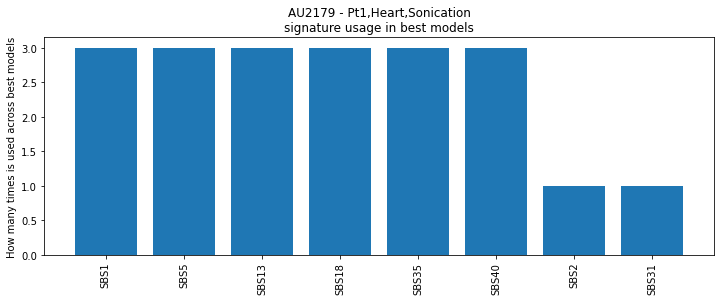

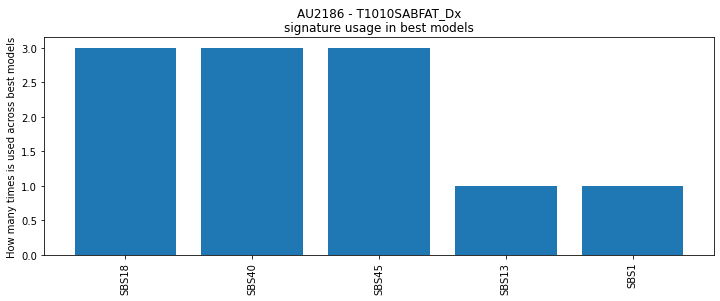

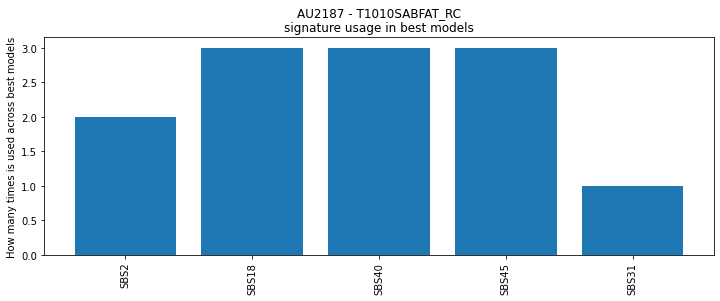

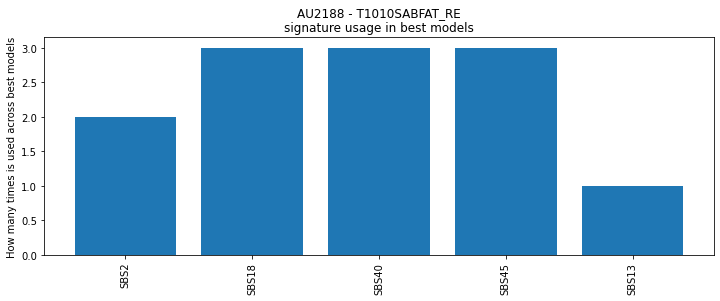

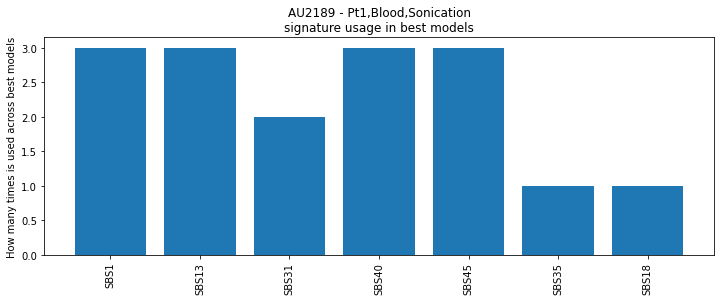

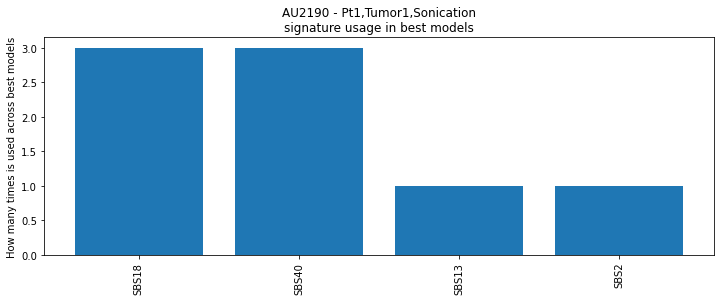

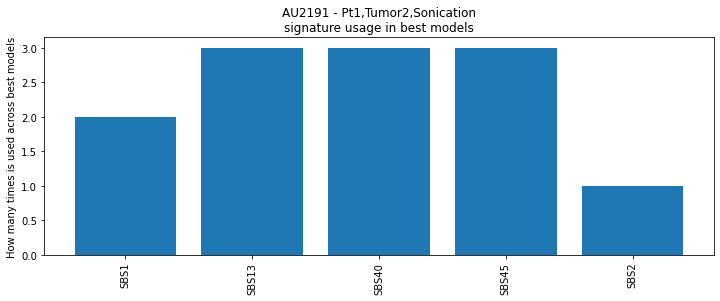

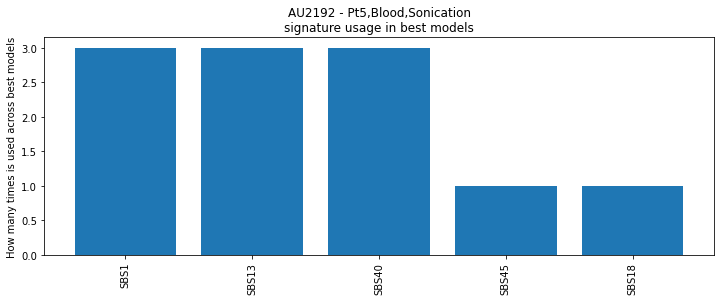

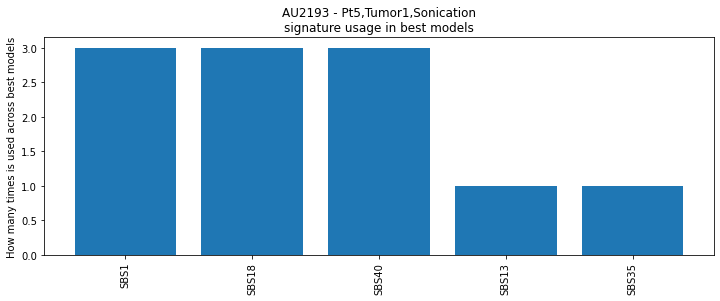

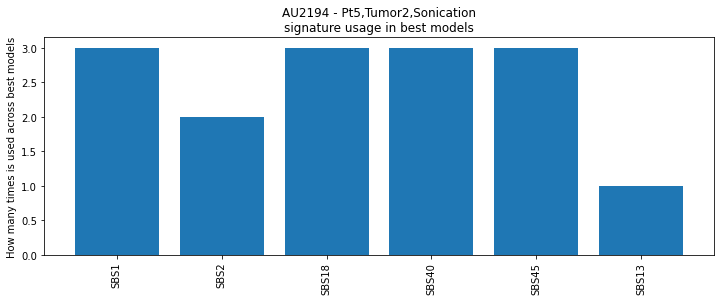

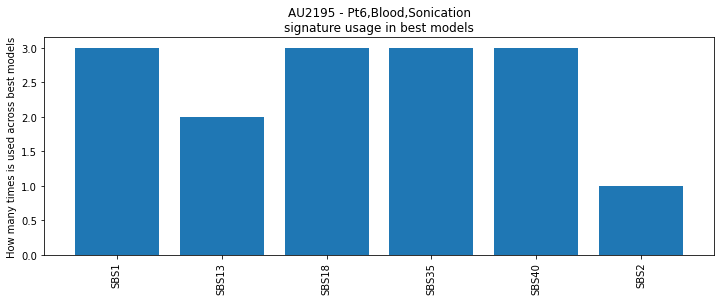

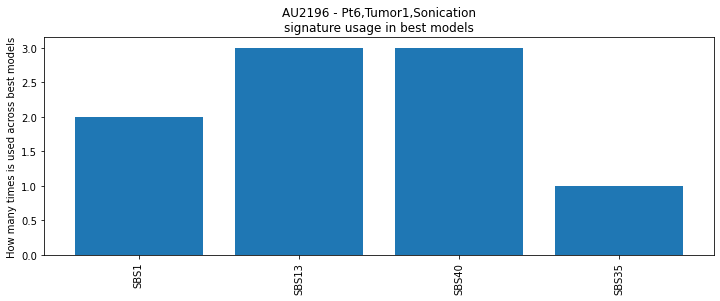

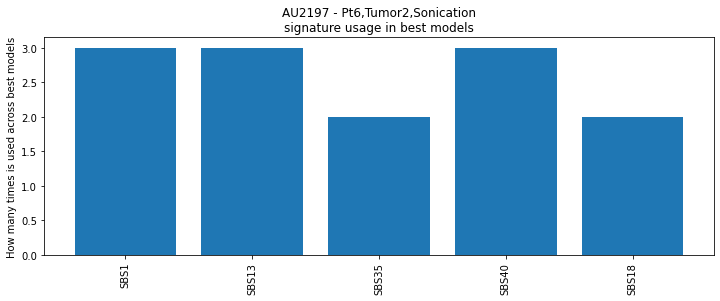

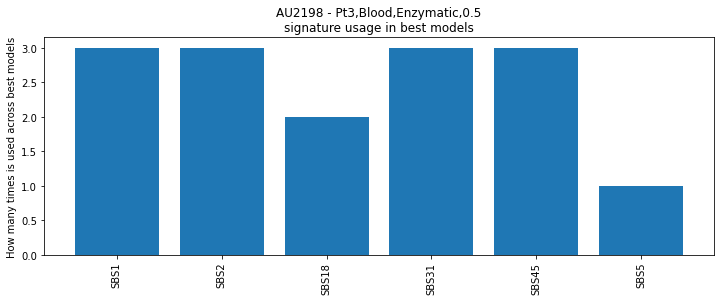

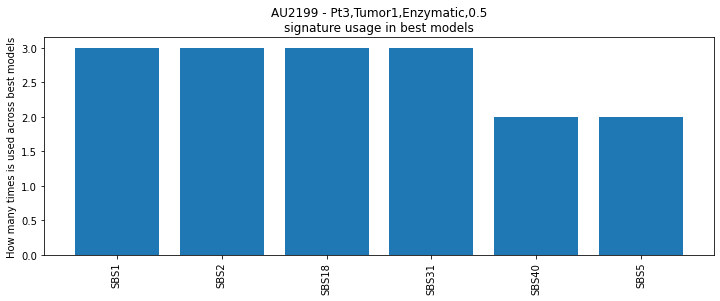

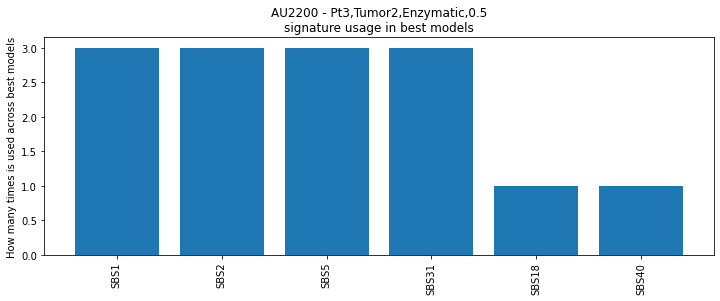

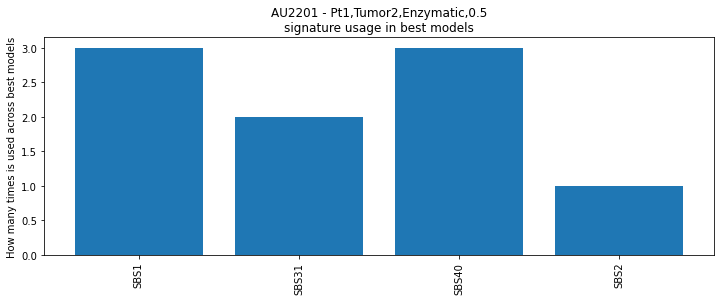

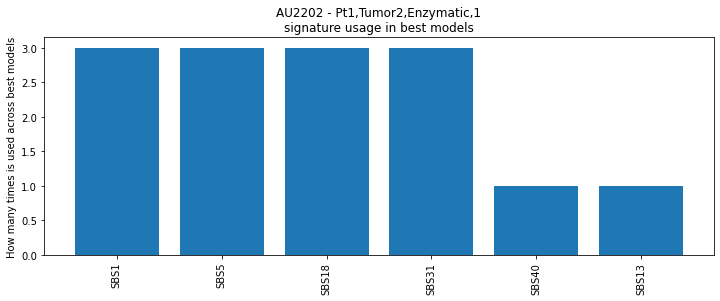

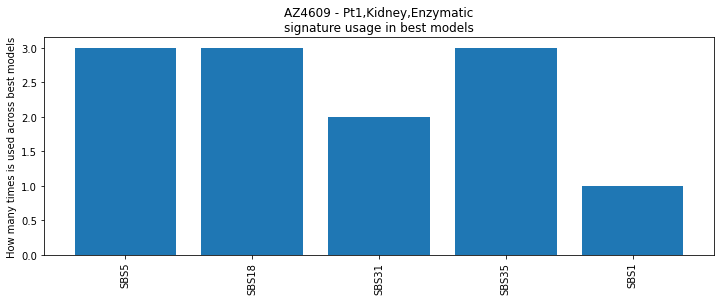

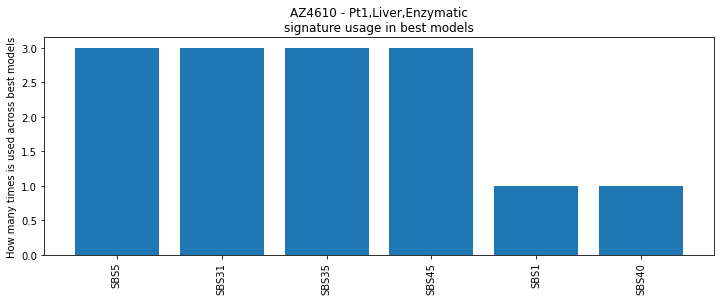

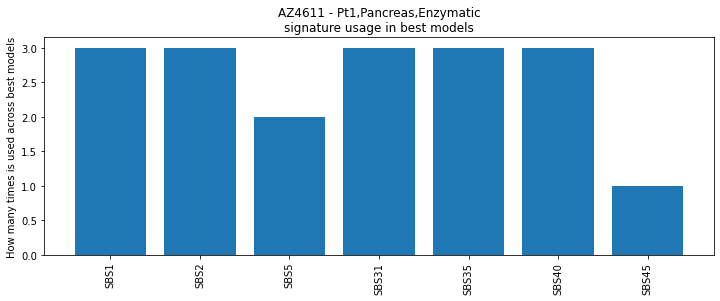

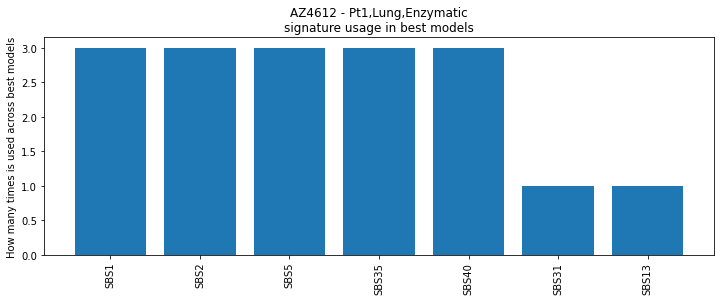

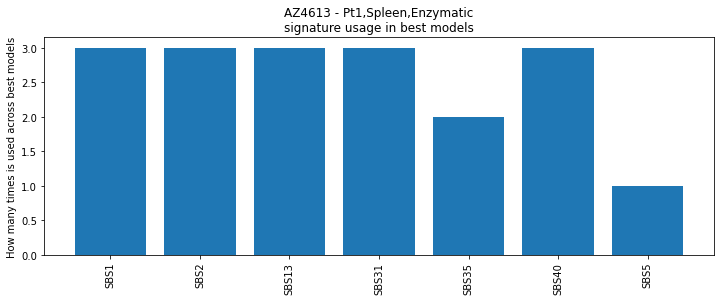

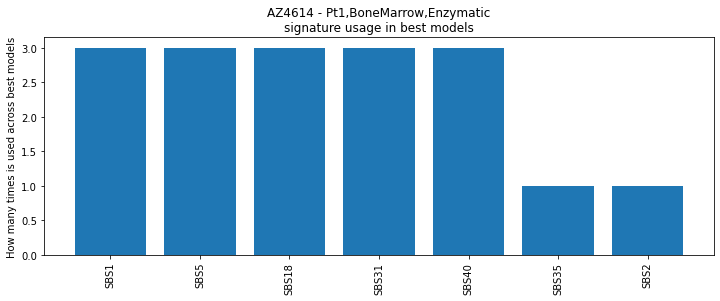

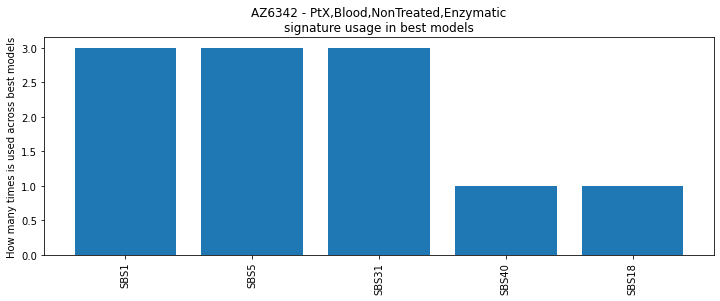

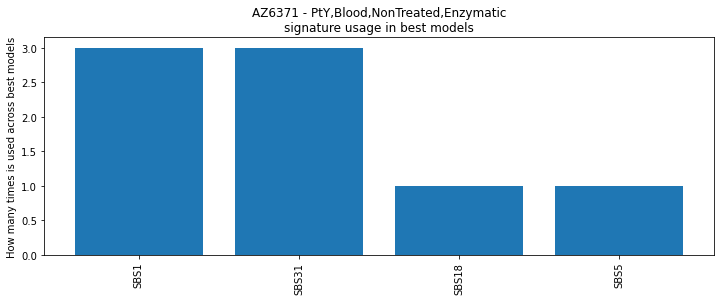

In [42]:
best_3_models_dict = {}
for sample_id in sample_ids:
    sample_type = sample_dict[sample_id]
    sorted_3_best_models = best_models(sample_id+' - '+sample_type,res_dict[sample_id],3)
    best_3_models_dict[sample_id] = sorted_3_best_models

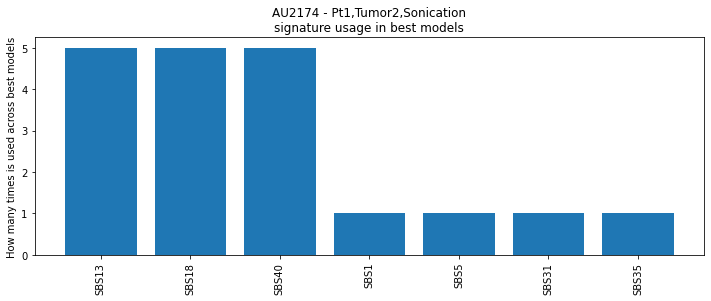

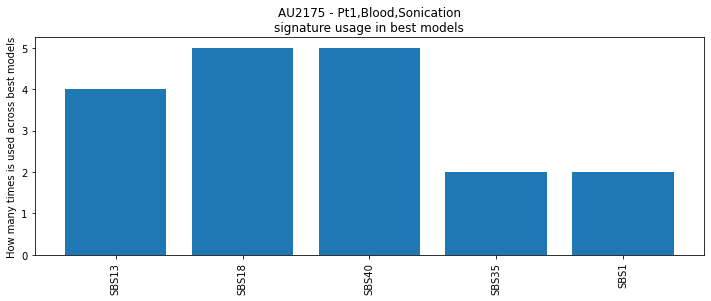

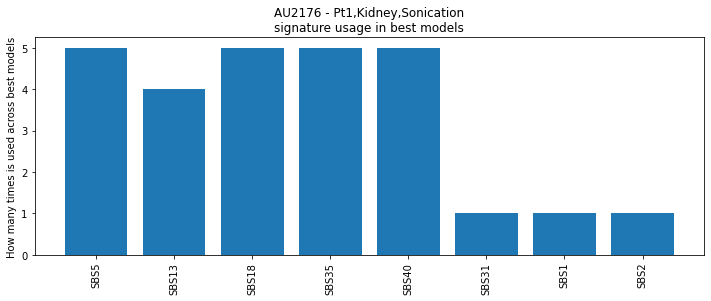

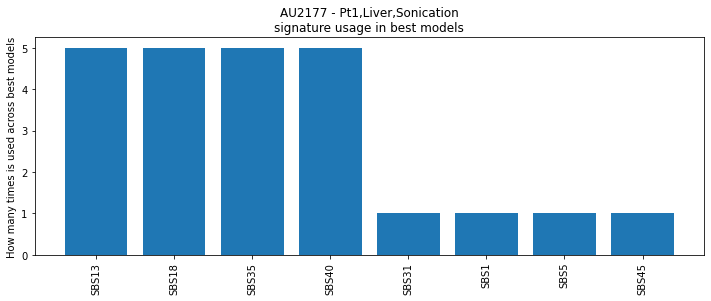

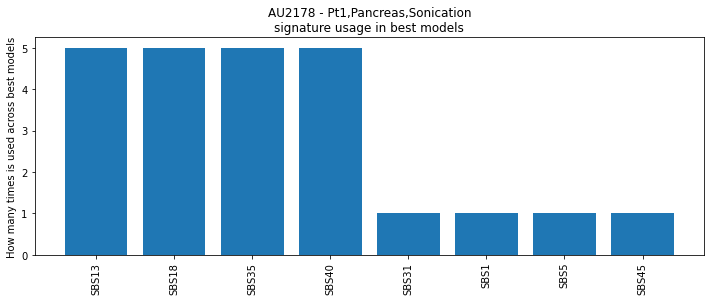

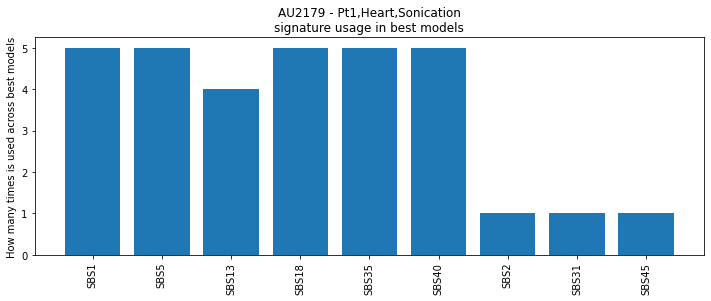

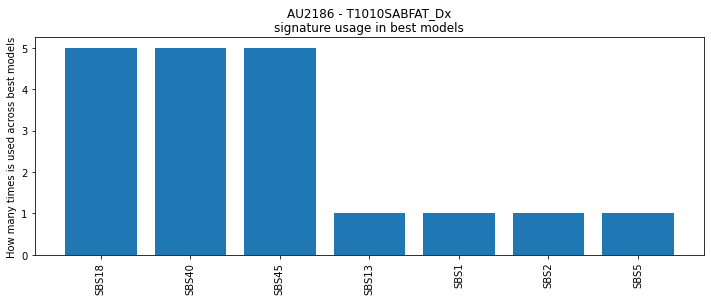

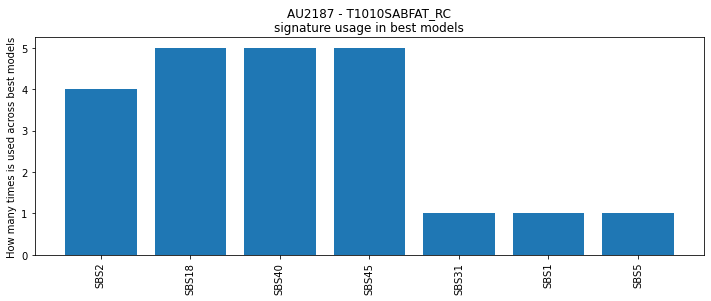

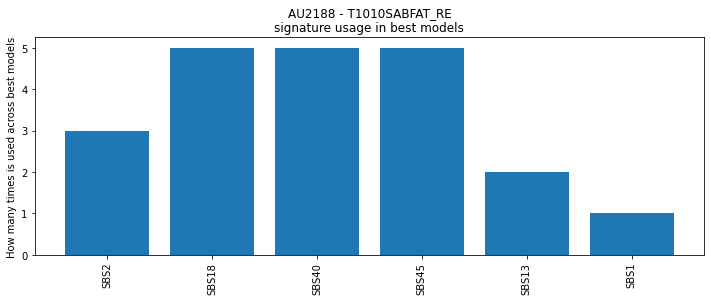

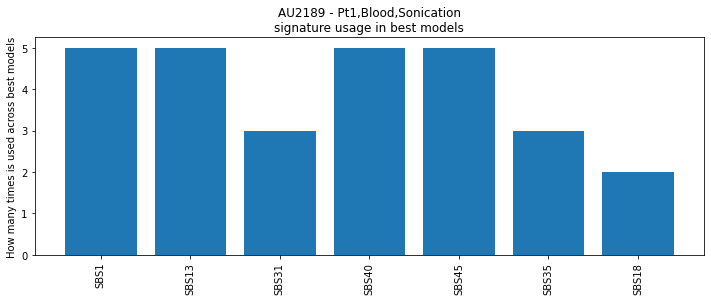

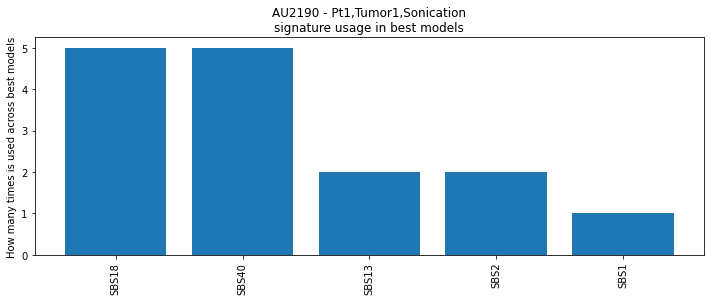

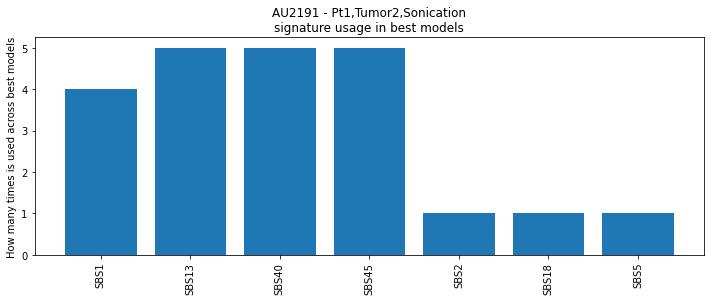

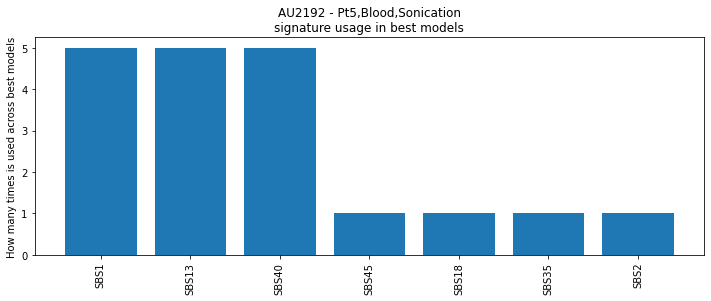

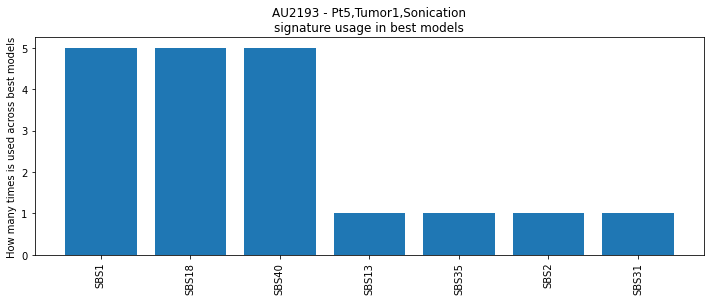

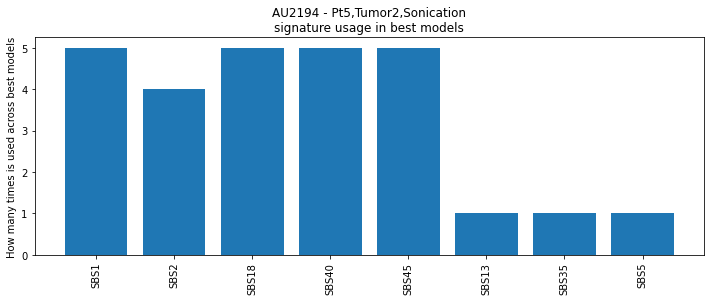

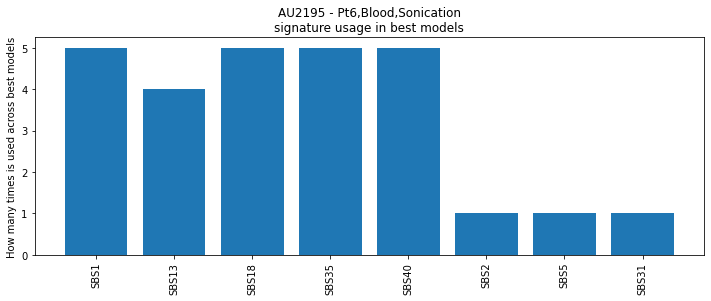

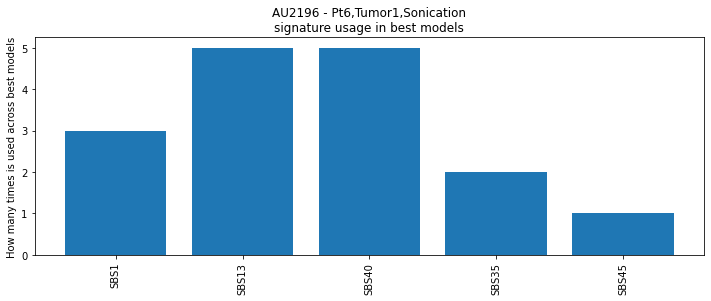

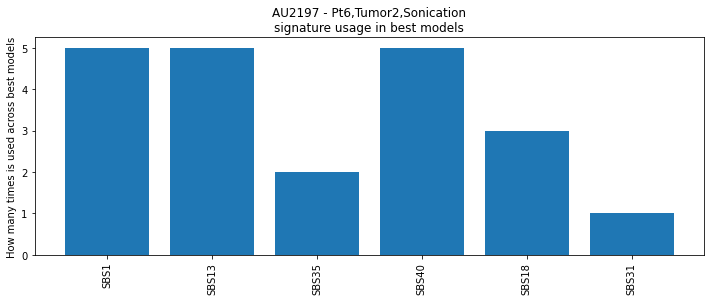

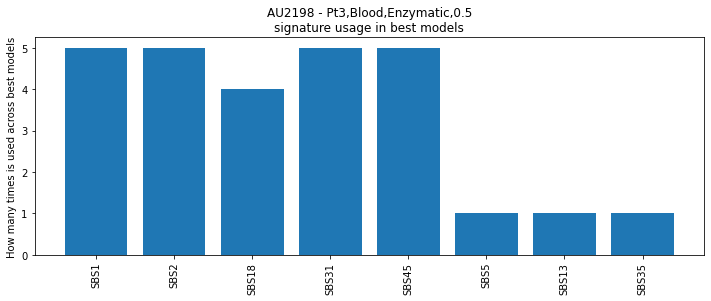

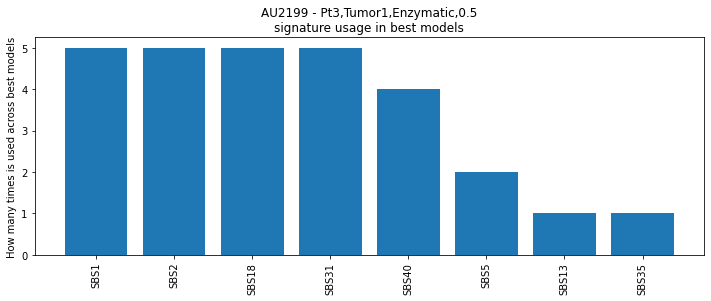

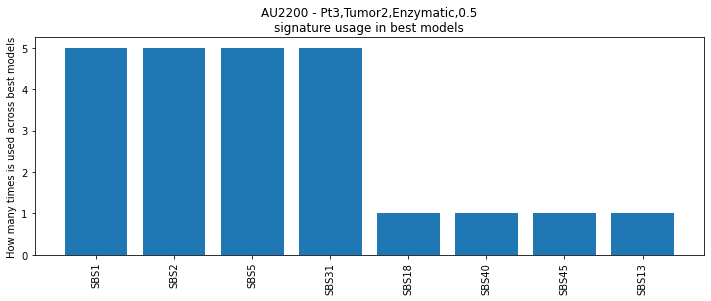

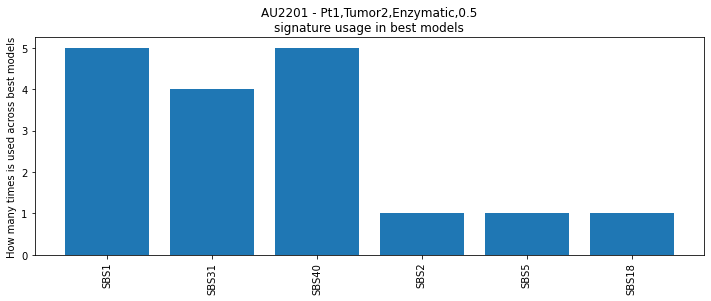

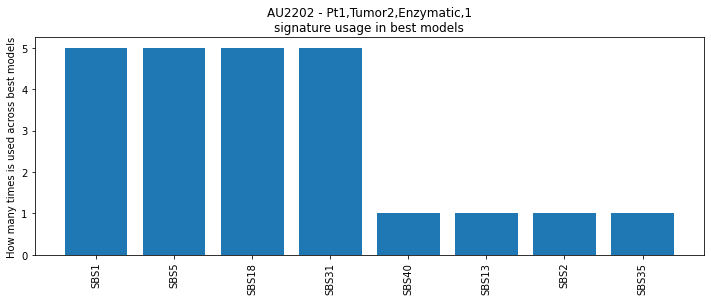

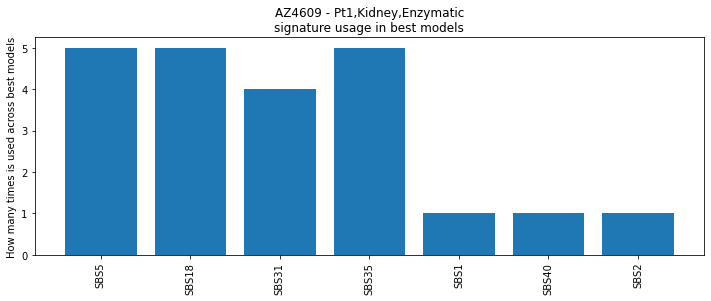

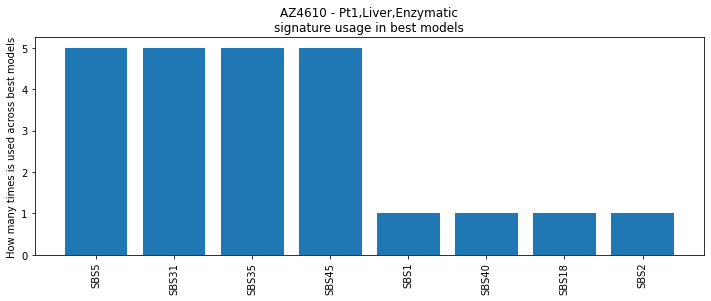

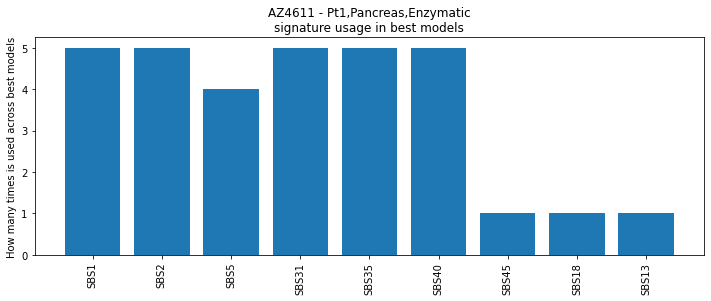

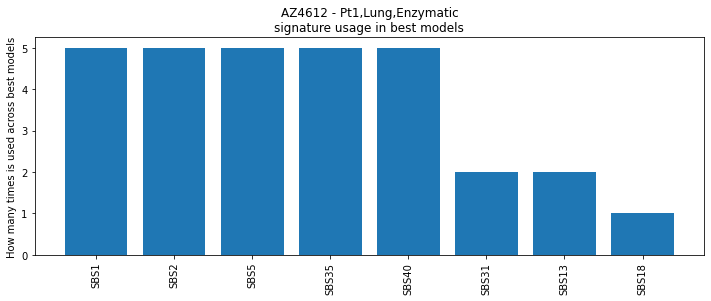

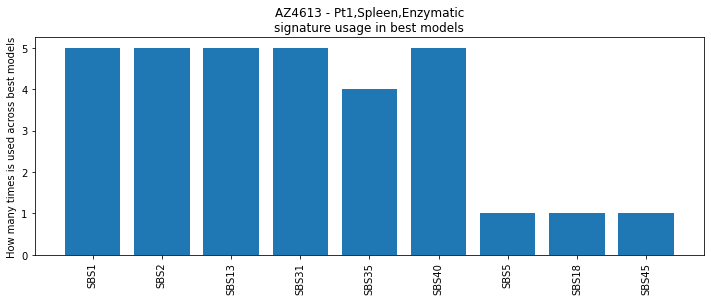

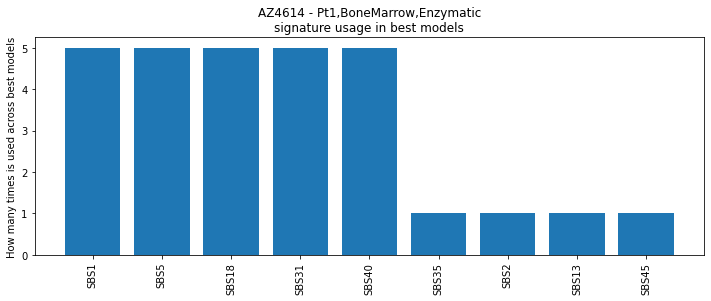

In [358]:
best_5_models_dict = {}
for sample_id in sample_ids:
    sample_type = sample_dict[sample_id]
    sorted_5_best_models = best_models(sample_id+' - '+sample_type,res_dict[sample_id],5)
    best_5_models_dict[sample_id] = sorted_5_best_models

In [39]:
sigs_3_models_per_sample_dict = {}
for sample in best_3_models_dict.keys():
    sigs_per_sample = []
    for i,model in enumerate(best_3_models_dict[sample]):
        sigs = best_3_models_dict[sample][i][0]
        sigs = list(sigs)
        sigs_per_sample += sigs
        sigs_per_sample = list(set(sigs_per_sample))
    sigs_3_models_per_sample_dict[sample] = sigs_per_sample
sigs_3_models_per_sample_dict

{'AU2174': ['SBS1', 'SBS40', 'SBS18', 'SBS5', 'SBS13'],
 'AU2175': ['SBS1', 'SBS40', 'SBS18', 'SBS13', 'SBS35'],
 'AU2176': ['SBS40', 'SBS31', 'SBS18', 'SBS5', 'SBS13', 'SBS35'],
 'AU2177': ['SBS1', 'SBS40', 'SBS31', 'SBS18', 'SBS13', 'SBS35'],
 'AU2178': ['SBS1', 'SBS40', 'SBS31', 'SBS18', 'SBS13', 'SBS35'],
 'AU2179': ['SBS1',
  'SBS40',
  'SBS31',
  'SBS2',
  'SBS18',
  'SBS5',
  'SBS13',
  'SBS35'],
 'AU2186': ['SBS1', 'SBS40', 'SBS18', 'SBS45', 'SBS13'],
 'AU2187': ['SBS40', 'SBS31', 'SBS2', 'SBS18', 'SBS45'],
 'AU2188': ['SBS40', 'SBS2', 'SBS18', 'SBS45', 'SBS13'],
 'AU2189': ['SBS1', 'SBS40', 'SBS31', 'SBS18', 'SBS45', 'SBS13', 'SBS35'],
 'AU2190': ['SBS18', 'SBS40', 'SBS13', 'SBS2'],
 'AU2191': ['SBS1', 'SBS40', 'SBS2', 'SBS45', 'SBS13'],
 'AU2192': ['SBS1', 'SBS40', 'SBS18', 'SBS45', 'SBS13'],
 'AU2193': ['SBS1', 'SBS40', 'SBS18', 'SBS13', 'SBS35'],
 'AU2194': ['SBS1', 'SBS40', 'SBS2', 'SBS18', 'SBS45', 'SBS13'],
 'AU2195': ['SBS1', 'SBS40', 'SBS2', 'SBS18', 'SBS13', 'SBS35'],

In [375]:
file = '/workspace/projects/sjd_pediatric_tumors/twinstrand_analysis/20230414_all_samples/signatures/msigact/sigs_from_combinatorial_refitting/sigs_per_sample.json'
json.dump(sigs_3_models_per_sample_dict,open(file,'w'))

In [369]:
sigs_5_models_per_sample_dict = {}
for sample in best_5_models_dict.keys():
    sigs_per_sample = []
    for i,model in enumerate(best_5_models_dict[sample]):
        sigs = best_5_models_dict[sample][i][0]
        sigs = list(sigs)
        sigs_per_sample += sigs
        sigs_per_sample = list(set(sigs_per_sample))
    sigs_5_models_per_sample_dict[sample] = sigs_per_sample
sigs_5_models_per_sample_dict

{'AU2174': ['SBS40', 'SBS5', 'SBS35', 'SBS13', 'SBS31', 'SBS18', 'SBS1'],
 'AU2175': ['SBS40', 'SBS35', 'SBS13', 'SBS18', 'SBS1'],
 'AU2176': ['SBS40',
  'SBS5',
  'SBS35',
  'SBS13',
  'SBS31',
  'SBS18',
  'SBS1',
  'SBS2'],
 'AU2177': ['SBS40',
  'SBS5',
  'SBS35',
  'SBS13',
  'SBS31',
  'SBS18',
  'SBS45',
  'SBS1'],
 'AU2178': ['SBS40',
  'SBS5',
  'SBS35',
  'SBS13',
  'SBS31',
  'SBS18',
  'SBS45',
  'SBS1'],
 'AU2179': ['SBS40',
  'SBS5',
  'SBS35',
  'SBS13',
  'SBS31',
  'SBS18',
  'SBS45',
  'SBS1',
  'SBS2'],
 'AU2186': ['SBS40', 'SBS5', 'SBS13', 'SBS18', 'SBS45', 'SBS1', 'SBS2'],
 'AU2187': ['SBS40', 'SBS5', 'SBS31', 'SBS18', 'SBS45', 'SBS1', 'SBS2'],
 'AU2188': ['SBS40', 'SBS13', 'SBS18', 'SBS45', 'SBS1', 'SBS2'],
 'AU2189': ['SBS40', 'SBS35', 'SBS13', 'SBS31', 'SBS18', 'SBS45', 'SBS1'],
 'AU2190': ['SBS40', 'SBS13', 'SBS18', 'SBS1', 'SBS2'],
 'AU2191': ['SBS40', 'SBS5', 'SBS13', 'SBS18', 'SBS45', 'SBS1', 'SBS2'],
 'AU2192': ['SBS40', 'SBS35', 'SBS13', 'SBS18', 'SBS45', 

In [370]:
sigs_per_sample_dict = {}
for sample in best_models_dict.keys():
    sigs_per_sample = []
    for i,model in enumerate(best_models_dict[sample]):
        sigs = best_models_dict[sample][i][0]
        sigs = list(sigs)
        sigs_per_sample += sigs
        sigs_per_sample = list(set(sigs_per_sample))
    sigs_per_sample_dict[sample] = sigs_per_sample
sigs_per_sample_dict

{'AU2174': ['SBS40',
  'SBS5',
  'SBS35',
  'SBS13',
  'SBS31',
  'SBS18',
  'SBS45',
  'SBS1',
  'SBS2'],
 'AU2175': ['SBS40',
  'SBS5',
  'SBS35',
  'SBS13',
  'SBS31',
  'SBS18',
  'SBS45',
  'SBS1',
  'SBS2'],
 'AU2176': ['SBS40',
  'SBS5',
  'SBS35',
  'SBS13',
  'SBS31',
  'SBS18',
  'SBS45',
  'SBS1',
  'SBS2'],
 'AU2177': ['SBS40',
  'SBS5',
  'SBS35',
  'SBS13',
  'SBS31',
  'SBS18',
  'SBS45',
  'SBS1',
  'SBS2'],
 'AU2178': ['SBS40',
  'SBS5',
  'SBS35',
  'SBS13',
  'SBS31',
  'SBS18',
  'SBS45',
  'SBS1',
  'SBS2'],
 'AU2179': ['SBS40',
  'SBS5',
  'SBS35',
  'SBS13',
  'SBS31',
  'SBS18',
  'SBS45',
  'SBS1',
  'SBS2'],
 'AU2186': ['SBS40',
  'SBS5',
  'SBS35',
  'SBS13',
  'SBS31',
  'SBS18',
  'SBS45',
  'SBS1',
  'SBS2'],
 'AU2187': ['SBS40',
  'SBS5',
  'SBS35',
  'SBS13',
  'SBS31',
  'SBS18',
  'SBS45',
  'SBS1',
  'SBS2'],
 'AU2188': ['SBS40',
  'SBS5',
  'SBS35',
  'SBS13',
  'SBS31',
  'SBS18',
  'SBS45',
  'SBS1',
  'SBS2'],
 'AU2189': ['SBS40',
  'SBS5',
  'SBS